## Rozwiązanie konkursowe Data AI - Awared Solution for Data: AI & Digital Analytics competition Hi-Tech Girls 
Agata Sowa

Ten notebook pokazuje proces przygotowania danych do dalszej analizy poprzez stworzenie wspólnego dataframe'u. Następnie przedstawione są wyniki i wizualizacje oparte na tych danych. Ostatecznie,  machine learning jest zatosowane w próbie przewidzenia anomalii występujących w BTS-ach

Rozpakowywanie plików - nazwa folderu zmieniona na```zadanie```

In [1]:
!unzip zadanie

Archive:  zadanie.zip
   creating: Zadanie dataai/
 extracting: Zadanie dataai/A_2017_H1.csv  
 extracting: Zadanie dataai/A_2017_H2.csv  
 extracting: Zadanie dataai/A_2022_H1.csv  
 extracting: Zadanie dataai/A_2022_H2.csv  
 extracting: Zadanie dataai/B_2017_H1.csv  
 extracting: Zadanie dataai/B_2017_H2.csv  
 extracting: Zadanie dataai/B_2022_H1.csv  
 extracting: Zadanie dataai/B_2022_H2.csv  
 extracting: Zadanie dataai/C_2017_H1.csv  
 extracting: Zadanie dataai/C_2017_H2.csv  
 extracting: Zadanie dataai/C_2022_H1.csv  
 extracting: Zadanie dataai/C_2022_H2.csv  
 extracting: Zadanie dataai/D_2017.csv  
 extracting: Zadanie dataai/D_2022.csv  
 extracting: Zadanie dataai/E_2017_H1.csv  
 extracting: Zadanie dataai/E_2017_H2.csv  
 extracting: Zadanie dataai/E_2022_H1.csv  
 extracting: Zadanie dataai/E_2022_H2.csv  
 extracting: Zadanie dataai/bts.csv  
 extracting: Zadanie dataai/bts_anomalie_pct.xlsx  
 extracting: Zadanie dataai/kody_parametr.csv  
 extracting: Zadanie data

In [2]:
!mv 'Zadanie dataai' 'zadanie'

In [3]:
!iconv -f Windows-1250 -t utf-8 zadanie/A_2017_H1.csv > zadanie/A_2017_H1_new.csv

In [65]:
#Potrzebne biblioteki
import pandas as pd
import codecs
import os
import chardet
import codecs
import matplotlib.pyplot as plt
import numpy as np
import pickle
from calendar import monthrange
import ee
import geemap
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from shapely.geometry import box

Konwersja plików na ```utf-8``` (z wyłączeniem ```.xlsx```).

In [5]:
def detect_encoding(file_path, chunk_size=1024):
    with open(file_path, 'rb') as f:
        raw_data = f.read(chunk_size)

    result = chardet.detect(raw_data)
    return result['encoding']

def convert_to_utf8(file_path):
    encoding = detect_encoding(file_path)
    
    if encoding == 'Windows-1252':encoding ='Windows-1250'
    print(encoding)

    with codecs.open(file_path, 'r', encoding=encoding, errors='ignore') as f:
        content = f.read()

    with codecs.open(file_path, 'w', encoding='utf-8') as f:
        f.write(content)

def convert_folder_to_utf8(folder_path, exclude_file):
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        if os.path.isfile(file_path) and file_path != exclude_file:
            print(f"Converting: {file_path}")
            convert_to_utf8(file_path)

folder_path = 'zadanie'
exclude_file = 'zadanie/bts_anomalie_pct.xlsx'

convert_folder_to_utf8(folder_path, exclude_file)


Converting: zadanie/E_2022_H1.csv
Windows-1250
Converting: zadanie/bts.csv
utf-8
Converting: zadanie/E_2017_H1.csv
Windows-1250
Converting: zadanie/D_2022.csv
Windows-1250
Converting: zadanie/B_2022_H2.csv
Windows-1250
Converting: zadanie/C_2017_H1.csv
Windows-1250
Converting: zadanie/A_2022_H1.csv
Windows-1250
Converting: zadanie/D_2017.csv
Windows-1250
Converting: zadanie/A_2017_H1.csv
Windows-1250
Converting: zadanie/B_2017_H2.csv
Windows-1250
Converting: zadanie/C_2022_H1.csv
Windows-1250
Converting: zadanie/A_2017_H2.csv
Windows-1250
Converting: zadanie/B_2017_H1.csv
Windows-1250
Converting: zadanie/C_2022_H2.csv
Windows-1250
Converting: zadanie/A_2017_H1_new.csv
utf-8
Converting: zadanie/B_2022_H1.csv
Windows-1250
Converting: zadanie/C_2017_H2.csv
Windows-1250
Converting: zadanie/A_2022_H2.csv
Windows-1250
Converting: zadanie/kody_parametr.csv
Windows-1250
Converting: zadanie/E_2017_H2.csv
Windows-1250
Converting: zadanie/kody_stacji.csv
Windows-1250
Converting: zadanie/E_2022_H2

Większość z plików miała inny encoding niż utf-8. Konwersja była konieczna, aby polskie znaki wyświetlały się w prawidłowy sposób. Program wykrywa encoding ```Windows-1252```, ale po sprawdzeniu plików okazało się, że znaki nie wyświetlają się poprawnie. Dlatego encoding ```Windows-1250``` został sprawdzony, potwierdzony jako właściwy encoding do plików. Dodatkowo, w niektórych plikach separatorem jest ```;```, a nie ```,```.

#### Sprawdzenie jak wyglądają pliki

In [66]:
with codecs.open('zadanie/A_2017_H1.csv', 'r', encoding='utf-8',
                 errors='ignore') as fdata:
    data_A_2017_H1 = pd.read_csv(fdata, sep=';')
data_A_2017_H1.tail()

,ID_stacji,Parametr,Data_godzina,Wartość
1019584,560,A,30.06.2017 19:00,"25,9"
1019585,560,A,30.06.2017 20:00,"22,5"
1019586,560,A,30.06.2017 21:00,"22,6"
1019587,560,A,30.06.2017 22:00,"22,5"
1019588,560,A,30.06.2017 23:00,"21,9"


In [67]:
with codecs.open('zadanie/A_2017_H2.csv', 'r', encoding='utf-8',
                 errors='ignore') as fdata:
    data_A_2017_H2 = pd.read_csv(fdata, sep=';')
data_A_2017_H2.head()

,ID_stacji,Parametr,Data_godzina,Wartość
0,538,A,01.07.2017 00:00,"16,2"
1,538,A,01.07.2017 01:00,"14,8"
2,538,A,01.07.2017 02:00,"15,6"
3,538,A,01.07.2017 03:00,"13,4"
4,538,A,01.07.2017 04:00,"15,9"


In [68]:
with codecs.open('zadanie/B_2017_H1.csv', 'r', encoding='utf-8',
                 errors='ignore') as fdata:
    data_B_2017_H1 = pd.read_csv(fdata, sep=';')
data_B_2017_H1.head()

,ID_stacji,Parametr,Data_godzina,Wartość
0,445,B,01.01.2017 00:00,"15,5"
1,445,B,01.01.2017 01:00,"14,4"
2,445,B,01.01.2017 02:00,"15,5"
3,445,B,01.01.2017 03:00,"15,0"
4,445,B,01.01.2017 04:00,"15,3"


Nie wszystkie dane są zapisane poprawnie. Na przykład, dane z parametru D zawierają puste rzędy, a pole ```ID_stacji``` jest zapisane jako ```float```, a nie jako ```int```. Po połączeniu danych D w jeden zbiór, ta informacja będzie wykorzystana do 'czyszczenia' danych.

In [69]:
with codecs.open('zadanie/D_2017.csv', 'r', encoding='utf-8',
                 errors='ignore') as fdata:
    data_D_2017 = pd.read_csv(fdata, sep=';')
data_D_2017.tail()

/tmp/ipykernel_157/3710003854.py:3: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_D_2017 = pd.read_csv(fdata, sep=';')


,ID_stacji,Parametr,Data_godzina,Wartość
1035968,NaN,NaN,NaN,NaN
1035969,NaN,NaN,NaN,NaN
1035970,NaN,NaN,NaN,NaN
1035971,NaN,NaN,NaN,NaN
1035972,NaN,NaN,NaN,NaN


In [70]:
with codecs.open('zadanie/kody_stacji.csv', 'r', encoding='utf-8',
                 errors='ignore') as fdata:
    kody_stacji = pd.read_csv(fdata, sep=';')
kody_stacji.head()

,ID,Nazwa,Szerokość geograficzna,Długość geograficzna
0,1,RYBNIK-STODOŁY,50 09 16,18 28 59
1,2,DZIWNÓW,54 01 20,14 43 54
2,3,ZIELENIEC,50 19 48,16 23 39
3,4,MIĘDZYGÓRZE,50 13 06,16 46 23
4,5,MIĘDZYLESIE,50 09 12,16 40 15


In [71]:
with codecs.open('zadanie/kody_parametr.csv', 'r', encoding='utf-8',
                 errors='ignore') as fdata:
    kody_parametr = pd.read_csv(fdata, sep=';')
#ten plik zawiera tylko 5 rzędów - nie ma potrzeby na .head()
kody_parametr

,Kod,Nazwa
0,A,Temperatura powietrza
1,B,Temperatura gruntu
2,C,Średnia prędkość wiatru
3,D,Suma opadu dobowego
4,E,Wilgotność względna powietrza


In [72]:
with codecs.open('zadanie/bts.csv', 'r', encoding='utf-8',
                 errors='ignore') as fdata:
    bts = pd.read_csv(fdata)

distinct_localizations = bts['lokalizacja'].nunique()
print("Numer różnych lokalizacji", distinct_localizations)
print("Różne sieci", bts['siec'].unique())
bts.tail()

Numer różnych lokalizacji 916
Różne sieci ['Konkurent_2' 'Orange' 'Konkurent_3' 'Konkurent_1']


,bts_id,siec,standard,lokalizacja
9913,9913,Konkurent_2,UMTS 5G,Błonie
9914,9914,Konkurent_2,LTE,Sandomierz
9915,9915,Orange,LTE,Gozdnica
9916,9916,Konkurent_2,UMTS LTE,Nowy Staw
9917,9917,Konkurent_2,GSM LTE 5G,Środa Śląska


In [73]:
# Kod edytowany przy użyciu ChatGPT
bts_anomalie = pd.read_excel('zadanie/bts_anomalie_pct.xlsx')
bts_anomalie.head()

,bts_id,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,...,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12
0,0,0.05,0.11,0.11,0.10,0.08,0.15,0.00,0.10,0.11,...,0.06,0.06,0.05,0.06,0.00,0.04,0.06,0.04,0.11,0.15
1,1,0.15,0.11,0.12,0.12,0.09,0.10,0.12,0.07,0.15,...,0.09,0.12,0.05,0.09,0.06,0.08,0.12,0.14,0.15,0.11
2,2,0.10,0.14,0.07,0.07,0.03,0.10,0.00,0.02,0.13,...,0.13,0.00,0.08,0.00,0.11,0.02,0.15,0.10,0.06,0.13
3,3,0.00,0.02,0.02,0.12,0.00,0.04,0.07,0.11,0.13,...,0.09,0.05,0.10,0.02,0.06,0.13,0.01,0.12,0.05,0.14
4,4,0.15,0.01,0.12,0.14,0.10,0.02,0.12,0.00,0.14,...,0.05,0.13,0.06,0.15,0.03,0.12,0.06,0.10,0.08,0.09


In [74]:
bts_anomalie.iloc[8628]

bts_id     8628.00
2017-01       0.09
2017-02       0.07
2017-03       0.12
2017-04       0.01
2017-05       0.07
2017-06       0.03
2017-07       0.02
2017-08       0.04
2017-09       0.14
2017-10       0.08
2017-11       0.12
2017-12       0.05
2022-01       0.10
2022-02       0.06
2022-03       0.06
2022-04       0.11
2022-05       0.09
2022-06       0.03
2022-07       0.11
2022-08       0.14
2022-09       0.05
2022-10       0.04
2022-11       0.09
2022-12       0.03
Name: 8628, dtype: float64

Pliki ```X_rok_H1``` i ```X_rok_H2``` zawierają dane z pierwszej ```H1``` i drugiej połowy roku ```H2```. Litera ```X``` jest nazwą parametru, który był mierzony. Jako pierwszy krok, dane z tym samym parametrem są łączone w jeden zbiór zawierający informacje o latach 2017 i 2022.

In [75]:
parametry = ['A', 'B', 'C', 'D', 'E']
dataframes = {}
folder_path = 'zadanie'

for file_name in os.listdir(folder_path):
    for parameter in parametry:
        if file_name.startswith(parameter):
            file_path = os.path.join(folder_path, file_name)
            separator = ';' 
            with codecs.open(file_path, 'r', encoding='utf-8', errors='ignore') as fdata:
                newdata = pd.read_csv(fdata, sep=separator)
            if parameter in dataframes:
                dataframes[parameter] = pd.concat([dataframes[parameter], newdata])
            else:
                dataframes[parameter] = newdata

/tmp/ipykernel_157/2685188902.py:11: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  newdata = pd.read_csv(fdata, sep=separator)
/tmp/ipykernel_157/2685188902.py:11: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  newdata = pd.read_csv(fdata, sep=separator)


In [76]:
dataframes['D'].dropna(subset=['ID_stacji'], inplace=True)
dataframes['D']['ID_stacji'] = dataframes['D']['ID_stacji'].astype(int)
dataframes['D'].tail()

,ID_stacji,Parametr,Data_godzina,Wartość
191471,561,D,27.12.2017 06:00,"8,9"
191472,561,D,28.12.2017 06:00,"0,3"
191473,561,D,29.12.2017 06:00,"0,6"
191474,561,D,30.12.2017 06:00,"0,7"
191475,561,D,31.12.2017 06:00,"0,7"


Jendak ja można zauważyc w poniższej komórce dla różnych parametrów i różnych okresów ```ID_stacji``` nie są takie same

In [77]:
diff_A_B = set(dataframes['A']['ID_stacji']).symmetric_difference(set(dataframes['B']['ID_stacji']))
diff_A_C = set(dataframes['A']['ID_stacji']).symmetric_difference(set(dataframes['C']['ID_stacji']))

print("Rożne stacje pomiędzy stacje_A_H1 and stacje_B_H1:")
print(diff_A_B)

print("\nRożne stacje pomiędzy stacje_A_H1 and stacje_A_H2:")
print(diff_A_C)

Rożne stacje pomiędzy stacje_A_H1 and stacje_B_H1:
{535, 87, 100, 118, 134, 142, 149, 194, 204, 281, 347, 365, 388, 462, 470, 509}

Rożne stacje pomiędzy stacje_A_H1 and stacje_A_H2:
{87, 100, 118, 142, 228, 365, 388, 462, 470, 509}


In [78]:
merged_data = None

for parameter, dataframe in dataframes.items():
    if merged_data is None:
        merged_data = dataframe
    else:
        merged_data = pd.merge(merged_data, dataframe, on=['ID_stacji', 'Data_godzina'], how='outer', suffixes=('', f'_{parameter}'))
        
merged_data.rename(columns={'Parametr': 'Parametr_E', 'Wartość': 'Wartość_E'}, inplace=True)
subset_cols = [col for col in merged_data.columns if col not in ['ID_stacji', 'Data_godzina']]
desired_columns = ['ID_stacji', 'Data_godzina'] + subset_cols
reordered_data = merged_data[desired_columns]

In [79]:
reordered_data.dropna(subset=['ID_stacji'], inplace=True)
reordered_data.dropna(subset=subset_cols, how='all', inplace=True)

reordered_data.tail()

,ID_stacji,Data_godzina,Parametr_E,Wartość_E,Parametr_D,Wartość_D,Parametr_B,Wartość_B,Parametr_C,Wartość_C,Parametr_A,Wartość_A
5552294,142,31.12.2022 22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,"14,2"
5552295,142,31.12.2022 23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,"15,5"
5552296,570,01.12.2022 08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,"0,7"
5552297,570,13.12.2022 11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,"-1,6"
5552298,407,23.12.2022 22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,"-1,1"


Jak można zauważyć, dane w kolumnie wartość są zapisane z przecinkiem jako separatorem dziesiętnym. W Pythonie preferowanym separatorem jest kropka. Dodatkowo, nazwy kolumn zostały zmienione tak, aby odzwierciedlały opis parametru.

In [80]:
wartosc_cols = [col for col in reordered_data.columns if col.startswith('Wartość')]
param_cols = [col for col in reordered_data.columns if col.startswith('Parametr')]

wartosc_map = dict(zip(kody_parametr['Kod'], kody_parametr['Nazwa']))

for col in wartosc_cols:
    reordered_data[col] = reordered_data[col].str.replace(',', '.').astype(float)
    col_code = col.split('_')[1]
    col_name = wartosc_map.get(col_code, f'Unknown_{col_code}')
    reordered_data.rename(columns={col: col_name}, inplace=True)

reordered_data.drop(param_cols, axis=1, inplace=True)
reordered_data.tail()

,ID_stacji,Data_godzina,Wilgotność względna powietrza,Suma opadu dobowego,Temperatura gruntu,Średnia prędkość wiatru,Temperatura powietrza
5552294,142,31.12.2022 22:00,NaN,NaN,NaN,NaN,14.2
5552295,142,31.12.2022 23:00,NaN,NaN,NaN,NaN,15.5
5552296,570,01.12.2022 08:00,NaN,NaN,NaN,NaN,0.7
5552297,570,13.12.2022 11:00,NaN,NaN,NaN,NaN,-1.6
5552298,407,23.12.2022 22:00,NaN,NaN,NaN,NaN,-1.1


Dodanie informacji o lokalizacji stacji

In [81]:
local_data = pd.merge(reordered_data, kody_stacji, left_on='ID_stacji', right_on='ID', how='left')
local_data.drop('ID', axis=1, inplace=True)
local_data.tail()

,ID_stacji,Data_godzina,Wilgotność względna powietrza,Suma opadu dobowego,Temperatura gruntu,Średnia prędkość wiatru,Temperatura powietrza,Nazwa,Szerokość geograficzna,Długość geograficzna
5552294,142,31.12.2022 22:00,NaN,NaN,NaN,NaN,14.2,SZCZECINEK,53 43 04,16 44 48
5552295,142,31.12.2022 23:00,NaN,NaN,NaN,NaN,15.5,SZCZECINEK,53 43 04,16 44 48
5552296,570,01.12.2022 08:00,NaN,NaN,NaN,NaN,0.7,KMIECIN,54 11 16,19 09 50
5552297,570,13.12.2022 11:00,NaN,NaN,NaN,NaN,-1.6,KMIECIN,54 11 16,19 09 50
5552298,407,23.12.2022 22:00,NaN,NaN,NaN,NaN,-1.1,PORONIN,49 19 49,20 02 07


Informacje o BTS zawierają puste znaki, dlatego przed ich dodaniem do głównego zbioru konieczne jest ich usunięcie

In [82]:
bts['lokalizacja'] = bts['lokalizacja'].str.upper()

bts['lokalizacja'].unique()[1]

'PIASKI   '

In [83]:
local_data[['Główna_nazwa', '_']] = local_data['Nazwa'].str.split('-', 1, expand=True)
local_data.tail()

,ID_stacji,Data_godzina,Wilgotność względna powietrza,Suma opadu dobowego,Temperatura gruntu,Średnia prędkość wiatru,Temperatura powietrza,Nazwa,Szerokość geograficzna,Długość geograficzna,Główna_nazwa,_
5552294,142,31.12.2022 22:00,NaN,NaN,NaN,NaN,14.2,SZCZECINEK,53 43 04,16 44 48,SZCZECINEK,None
5552295,142,31.12.2022 23:00,NaN,NaN,NaN,NaN,15.5,SZCZECINEK,53 43 04,16 44 48,SZCZECINEK,None
5552296,570,01.12.2022 08:00,NaN,NaN,NaN,NaN,0.7,KMIECIN,54 11 16,19 09 50,KMIECIN,None
5552297,570,13.12.2022 11:00,NaN,NaN,NaN,NaN,-1.6,KMIECIN,54 11 16,19 09 50,KMIECIN,None
5552298,407,23.12.2022 22:00,NaN,NaN,NaN,NaN,-1.1,PORONIN,49 19 49,20 02 07,PORONIN,None


In [84]:
bts['lokalizacja'] = bts['lokalizacja'].str.strip()

In [85]:
diff_loc_bts = set(local_data['Główna_nazwa']) - set(bts['lokalizacja'])

diff_bts_loc = set(bts['lokalizacja']) - set(local_data['Główna_nazwa'])

# z printów wynika że dane od bts mają wiecej lokalizacji
# print("Rożne stacje pomiędzy lokalizacją i bts:")
# print(diff_loc_bts)

# print("Rożne stacje pomiędzy bts i lokalizacją:")
# print(diff_bts_loc)


In [86]:
bts_merged = pd.merge(local_data, bts, left_on='Główna_nazwa', right_on='lokalizacja', how='left')
bts_merged = bts_merged[bts_merged['Główna_nazwa'].notnull()]
bts_merged.drop('lokalizacja', axis=1, inplace=True)
bts_merged.drop('_', axis=1, inplace=True)
bts_merged.drop('Główna_nazwa', axis=1, inplace=True)
bts_merged.tail()

,ID_stacji,Data_godzina,Wilgotność względna powietrza,Suma opadu dobowego,Temperatura gruntu,Średnia prędkość wiatru,Temperatura powietrza,Nazwa,Szerokość geograficzna,Długość geograficzna,bts_id,siec,standard
31744985,142,31.12.2022 23:00,NaN,NaN,NaN,NaN,15.5,SZCZECINEK,53 43 04,16 44 48,6544.0,Konkurent_2,UMTS
31744986,142,31.12.2022 23:00,NaN,NaN,NaN,NaN,15.5,SZCZECINEK,53 43 04,16 44 48,9319.0,Konkurent_3,LTE IOT
31744987,570,01.12.2022 08:00,NaN,NaN,NaN,NaN,0.7,KMIECIN,54 11 16,19 09 50,NaN,NaN,NaN
31744988,570,13.12.2022 11:00,NaN,NaN,NaN,NaN,-1.6,KMIECIN,54 11 16,19 09 50,NaN,NaN,NaN
31744989,407,23.12.2022 22:00,NaN,NaN,NaN,NaN,-1.1,PORONIN,49 19 49,20 02 07,NaN,NaN,NaN


I na koniec dodanie informacji o anomaliach bts

In [87]:
bts_anomalie_melt = bts_anomalie.melt(id_vars='bts_id', var_name='Data', value_name='Anomalia')
bts_anomalie_melt['Data'] = pd.to_datetime(bts_anomalie_melt['Data'])
bts_anomalie_melt.tail()

,bts_id,Data,Anomalia
238027,9913,2022-12-01,0.05
238028,9914,2022-12-01,0.08
238029,9915,2022-12-01,0.06
238030,9916,2022-12-01,0.10
238031,9917,2022-12-01,0.01


Nie dla wszystkich rzędów wartość BTS jest znana, dlatego został stworzony dataframe ```bts_nan```, który jest później dołączany do pozostałych, aby nie stracić informacji o stacjach, dla których nie ma danych o BTS.

In [88]:
bts_merged['Data_godzina'] = pd.to_datetime(bts_merged['Data_godzina'])
bts_nan = bts_merged[pd.isnull(bts_merged['bts_id'])].copy()
bts_nan.loc[:, 'Anomalia'] = np.nan
bts_nan.reset_index(drop=True, inplace=True)
final_data = pd.merge(bts_merged, bts_anomalie_melt, left_on=['bts_id', bts_merged['Data_godzina'].dt.to_period('M')], 
                      right_on=['bts_id', bts_anomalie_melt['Data'].dt.to_period('M')], how='inner')

final_data.drop('key_1', axis=1, inplace=True)
final_data.drop('Data', axis=1, inplace=True)
final_data['bts_id'] = final_data['bts_id'].astype(int)
final_data = pd.concat([final_data, bts_nan])

final_data.tail()

,ID_stacji,Data_godzina,Wilgotność względna powietrza,Suma opadu dobowego,Temperatura gruntu,Średnia prędkość wiatru,Temperatura powietrza,Nazwa,Szerokość geograficzna,Długość geograficzna,bts_id,siec,standard,Anomalia
2837819,369,2022-11-24 22:00:00,NaN,NaN,NaN,NaN,-1.40,SIELEC,50 19 07,20 25 14,NaN,NaN,NaN,NaN
2837820,536,2022-02-11 10:00:00,NaN,NaN,NaN,NaN,12.52,DRONIOWICE,50 41 43,18 48 29,NaN,NaN,NaN,NaN
2837821,570,2022-01-12 08:00:00,NaN,NaN,NaN,NaN,0.70,KMIECIN,54 11 16,19 09 50,NaN,NaN,NaN,NaN
2837822,570,2022-12-13 11:00:00,NaN,NaN,NaN,NaN,-1.60,KMIECIN,54 11 16,19 09 50,NaN,NaN,NaN,NaN
2837823,407,2022-12-23 22:00:00,NaN,NaN,NaN,NaN,-1.10,PORONIN,49 19 49,20 02 07,NaN,NaN,NaN,NaN


In [89]:
final_data['ID_stacji'].nunique()

545

Jak można zauważyć, długość i szerokość geograficzna nie są poprawnie zapisane, albo nie są zapisane w formacie umożliwiającym łatwe określenie punktów na mapie

In [90]:
def value_to_decimal(value):
    degrees, minutes, seconds = map(float, value.split())
    return degrees + minutes / 60 + seconds / 3600

final_data['Szerokość geograficzna'] = final_data['Szerokość geograficzna'].apply(value_to_decimal)
final_data['Długość geograficzna'] = final_data['Długość geograficzna'].apply(value_to_decimal) 

final_data.head()

,ID_stacji,Data_godzina,Wilgotność względna powietrza,Suma opadu dobowego,Temperatura gruntu,Średnia prędkość wiatru,Temperatura powietrza,Nazwa,Szerokość geograficzna,Długość geograficzna,bts_id,siec,standard,Anomalia
0,2,2022-01-01 00:00:00,97.0,NaN,5.2,6.7,5.0,DZIWNÓW,54.022222,14.731667,100.0,Orange,GSM UMTS,0.04
1,2,2022-01-01 01:00:00,97.0,NaN,6.5,8.3,6.5,DZIWNÓW,54.022222,14.731667,100.0,Orange,GSM UMTS,0.04
2,2,2022-01-01 02:00:00,95.0,NaN,5.6,7.9,6.1,DZIWNÓW,54.022222,14.731667,100.0,Orange,GSM UMTS,0.04
3,2,2022-01-01 03:00:00,95.0,NaN,6.6,5.6,5.2,DZIWNÓW,54.022222,14.731667,100.0,Orange,GSM UMTS,0.04
4,2,2022-01-01 04:00:00,97.0,NaN,5.7,5.7,5.0,DZIWNÓW,54.022222,14.731667,100.0,Orange,GSM UMTS,0.04


Zapisanie finalnego dataframe'u

In [32]:
with open('final_data', 'wb') as file:
    pickle.dump(final_data, file)

In [33]:
with open('final_data', 'rb') as file:
    final_data = pickle.load(file)

Średnia dobowa - liczona tylko dla wartość które nie są Nan

_Wykonanie komórki zajmuje więcej czasu_

In [91]:
value_cols = kody_parametr['Nazwa'].unique().tolist()
final_data['Data_godzina'] = pd.to_datetime(final_data['Data_godzina'])

def nan_mean(x):
    if np.isnan(x.values).all():
        return np.nan
    else:
        return np.nanmean(x)


agg_funcs = {}
for col in final_data.columns:
    if col in value_cols:
        agg_funcs[col] = nan_mean
    else:
        agg_funcs[col] = 'first'

day_avg = final_data.groupby(['ID_stacji', final_data['Data_godzina'].dt.date]).agg(agg_funcs)
day_avg.tail()

ID_stacji Data_godzina  Wilgotność względna powietrza  \
ID_stacji Data_godzina                                                          
570       2022-12-27          570   2022-12-27                      87.000000   
          2022-12-28          570   2022-12-28                      92.095238   
          2022-12-29          570   2022-12-29                      91.352941   
          2022-12-30          570   2022-12-30                      87.043478   
          2022-12-31          570   2022-12-31                      89.850000   

                        Suma opadu dobowego  Temperatura gruntu  \
ID_stacji Data_godzina                                            
570       2022-12-27                    3.4            3.066667   
          2022-12-28                    0.2            3.152381   
          2022-12-29                    1.7            7.082353   
          2022-12-30                    1.0            5.530435   
          2022-12-31                    0.8            9.150000   

                        Średnia prędkość wiatru  Temperatura powietrza  \
ID_stacji Data_godzina                                                   
570       2022-12-27                   5.609524               3.014286   
          2022-12-28                   6.642857               2.542857   
          2022-12-29                   6.400000               6.594118   
          2022-12-30                   5.604348               5.418182   
          2022-12-31                   7.460000               8.700000   

                          Nazwa  Szerokość geograficzna  Długość geograficzna  \
ID_stacji Data_godzina                                                          
570       2022-12-27    KMIECIN               54.187778             19.163889   
          2022-12-28    KMIECIN               54.187778             19.163889   
          2022-12-29    KMIECIN               54.187778             19.163889   
          2022-12-30    KMIECIN               54.187778             19.163889   
          2022-12-31    KMIECIN               54.187778             19.163889   

                        bts_id  siec standard  Anomalia  
ID_stacji Data_godzina                                   
570       2022-12-27       NaN  None     None       NaN  
          2022-12-28       NaN  None     None       NaN  
          2022-12-29       NaN  None     None       NaN  
          2022-12-30       NaN  None     None       NaN  
          2022-12-31       NaN  None     None       NaN

Średnia miesięczna

In [92]:
month_avg = final_data.groupby(['ID_stacji', final_data['Data_godzina'].dt.to_period('M')]).agg(agg_funcs)
month_avg.tail()

ID_stacji Data_godzina  Wilgotność względna powietrza  \
ID_stacji Data_godzina                                                          
570       2022-08             570   2022-08-01                      77.606513   
          2022-09             570   2022-09-01                      82.938375   
          2022-10             570   2022-10-01                      86.208163   
          2022-11             570   2022-11-01                      85.310984   
          2022-12             570   2022-12-01                      86.013514   

                        Suma opadu dobowego  Temperatura gruntu  \
ID_stacji Data_godzina                                            
570       2022-08                  2.280645           18.716011   
          2022-09                  2.950000           11.281513   
          2022-10                  0.735484           10.536190   
          2022-11                  1.020000            5.439429   
          2022-12                  1.532143            4.817444   

                        Średnia prędkość wiatru  Temperatura powietrza  \
ID_stacji Data_godzina                                                   
570       2022-08                      4.079647              17.260516   
          2022-09                      3.983333              10.414706   
          2022-10                      3.857415               9.891553   
          2022-11                      3.729857               4.399000   
          2022-12                      4.771880               3.979154   

                          Nazwa  Szerokość geograficzna  Długość geograficzna  \
ID_stacji Data_godzina                                                          
570       2022-08       KMIECIN               54.187778             19.163889   
          2022-09       KMIECIN               54.187778             19.163889   
          2022-10       KMIECIN               54.187778             19.163889   
          2022-11       KMIECIN               54.187778             19.163889   
          2022-12       KMIECIN               54.187778             19.163889   

                        bts_id  siec standard  Anomalia  
ID_stacji Data_godzina                                   
570       2022-08          NaN  None     None       NaN  
          2022-09          NaN  None     None       NaN  
          2022-10          NaN  None     None       NaN  
          2022-11          NaN  None     None       NaN  
          2022-12          NaN  None     None       NaN

In [93]:
month_avg.head()

ID_stacji        Data_godzina  \
ID_stacji Data_godzina                                  
1         2017-01               1 2017-01-01 06:00:00   
          2017-02               1 2017-02-01 06:00:00   
          2017-03               1 2017-03-01 06:00:00   
          2017-04               1 2017-04-01 06:00:00   
          2017-05               1 2017-05-01 06:00:00   

                        Wilgotność względna powietrza  Suma opadu dobowego  \
ID_stacji Data_godzina                                                       
1         2017-01                                 NaN             2.174194   
          2017-02                                 NaN             2.567857   
          2017-03                                 NaN             1.609677   
          2017-04                                 NaN             1.933333   
          2017-05                                 NaN             2.312903   

                        Temperatura gruntu  Średnia prędkość wiatru  \
ID_stacji Data_godzina                                                
1         2017-01                      NaN                      NaN   
          2017-02                      NaN                      NaN   
          2017-03                      NaN                      NaN   
          2017-04                      NaN                      NaN   
          2017-05                      NaN                      NaN   

                        Temperatura powietrza           Nazwa  \
ID_stacji Data_godzina                                          
1         2017-01                         NaN  RYBNIK-STODOŁY   
          2017-02                         NaN  RYBNIK-STODOŁY   
          2017-03                         NaN  RYBNIK-STODOŁY   
          2017-04                         NaN  RYBNIK-STODOŁY   
          2017-05                         NaN  RYBNIK-STODOŁY   

                        Szerokość geograficzna  Długość geograficzna  bts_id  \
ID_stacji Data_godzina                                                         
1         2017-01                    50.154444             18.483056   342.0   
          2017-02                    50.154444             18.483056   342.0   
          2017-03                    50.154444             18.483056   342.0   
          2017-04                    50.154444             18.483056   342.0   
          2017-05                    50.154444             18.483056   342.0   

                               siec standard  Anomalia  
ID_stacji Data_godzina                                  
1         2017-01       Konkurent_2      IOT      0.02  
          2017-02       Konkurent_2      IOT      0.03  
          2017-03       Konkurent_2      IOT      0.03  
          2017-04       Konkurent_2      IOT      0.15  
          2017-05       Konkurent_2      IOT      0.08

## Analiza danych

**Zmiany w numerze stacji**

In [94]:
# final_data['Data_godzina'] = pd.to_datetime(final_data['Data_godzina'])

data_2017 = final_data[final_data['Data_godzina'].dt.year == 2017]
unique_stations_2017 = data_2017['ID_stacji'].nunique()

data_2022 = final_data[final_data['Data_godzina'].dt.year == 2022]
unique_stations_2022 = data_2022['ID_stacji'].nunique()

diff_2022_2017 = set(data_2022['ID_stacji']) - set(data_2017['ID_stacji'])

print("Numer różnych stacji w 2017: ", unique_stations_2017)
print("Numer różnych stacji w 2022:", unique_stations_2022)
print("Stacje które się różnią: ", diff_2022_2017)

Numer różnych stacji w 2017:  545
Numer różnych stacji w 2022: 545
Stacje które się różnią:  set()


W ciągu 5 lat nie przybyło żadnych stacji, dodatkowe stacje z 2017 roku sa tymi samymi stacjami z 2022

**Największe zaobserwowane zmiany**

In [95]:
month_avg.rename(columns={'ID_stacji' : 'ID'}, inplace=True)

value_cols = kody_parametr['Nazwa'].unique().tolist()
differences = {}

for year in [2017, 2022]:
    differences[year]={}
    data_year = month_avg[month_avg['Data_godzina'].dt.year == year]
    for value in value_cols:
        diff = data_year.groupby('ID')[value].agg(lambda x : x.max() - x.min())
        if not diff.empty:
            max_station = diff.idxmax()
            max_diff = diff.max()
            differences[year][value] = {'Station_ID': max_station, 'Max_Difference': max_diff}
        else:
            differences[year][value] = {'Station_ID': None, 'Max_Difference': None}

for year, year_diffs in differences.items():
    print(f"Rok: {year}")
    for value, details in year_diffs.items():
        print(f"Parametr: {value}, ID stacji: {details['Station_ID']}, Największa różnica: {details['Max_Difference']}")

Rok: 2017
Parametr: Temperatura powietrza, ID stacji: 315, Największa różnica: 15.688210173314339
Parametr: Temperatura gruntu, ID stacji: 291, Największa różnica: 16.465335849386395
Parametr: Średnia prędkość wiatru, ID stacji: 316, Największa różnica: 131.32803671403963
Parametr: Suma opadu dobowego, ID stacji: 482, Największa różnica: 9.257954545454547
Parametr: Wilgotność względna powietrza, ID stacji: 315, Największa różnica: 42.30756117724869
Rok: 2022
Parametr: Temperatura powietrza, ID stacji: 315, Największa różnica: 15.940028735632184
Parametr: Temperatura gruntu, ID stacji: 291, Największa różnica: 16.4624156836355
Parametr: Średnia prędkość wiatru, ID stacji: 316, Największa różnica: 157.44902158774372
Parametr: Suma opadu dobowego, ID stacji: 315, Największa różnica: 9.158333333333331
Parametr: Wilgotność względna powietrza, ID stacji: 315, Największa różnica: 41.04240636200717


Porównanie danych na wykreseach z 2017 i 2022.

In [96]:
selected_stations_2017 = [315, 222, 316, 315, 315]
selected_stations_2022 = [315, 291, 316, 315, 315]

month_avg['Data_godzina'] = pd.to_datetime(month_avg['Data_godzina'])

filtered_data_2017 = month_avg[(month_avg['ID'].isin(selected_stations_2017)) & 
                               (month_avg['Data_godzina'].dt.year == 2017)]

filtered_data_2017 = filtered_data_2017[['ID', 'Data_godzina'] + value_cols]

filtered_data_2022 = month_avg[(month_avg['ID'].isin(selected_stations_2022)) & 
                               (month_avg['Data_godzina'].dt.year == 2022)]

filtered_data_2022 = filtered_data_2022[['ID', 'Data_godzina'] + value_cols]

filtered_data_2022.head()

ID Data_godzina  Temperatura powietrza  \
ID_stacji Data_godzina                                            
291       2022-01       291   2022-01-01               1.139569   
          2022-02       291   2022-02-01               4.038746   
          2022-03       291   2022-03-01               5.502621   
          2022-04       291   2022-04-01               7.245911   
          2022-05       291   2022-05-01              11.341430   

                        Temperatura gruntu  Średnia prędkość wiatru  \
ID_stacji Data_godzina                                                
291       2022-01                 1.508614                 3.974059   
          2022-02                 4.437946                 4.162351   
          2022-03                 5.637634                 2.746640   
          2022-04                 7.851878                 3.077747   
          2022-05                12.515250                 3.209299   

                        Suma opadu dobowego  Wilgotność względna powietrza  
ID_stacji Data_godzina                                                      
291       2022-01                  2.454839                      78.738280  
          2022-02                  3.114286                      75.923095  
          2022-03                  1.106452                      61.880726  
          2022-04                  1.756667                      72.969124  
          2022-05                  0.876667                      68.566698

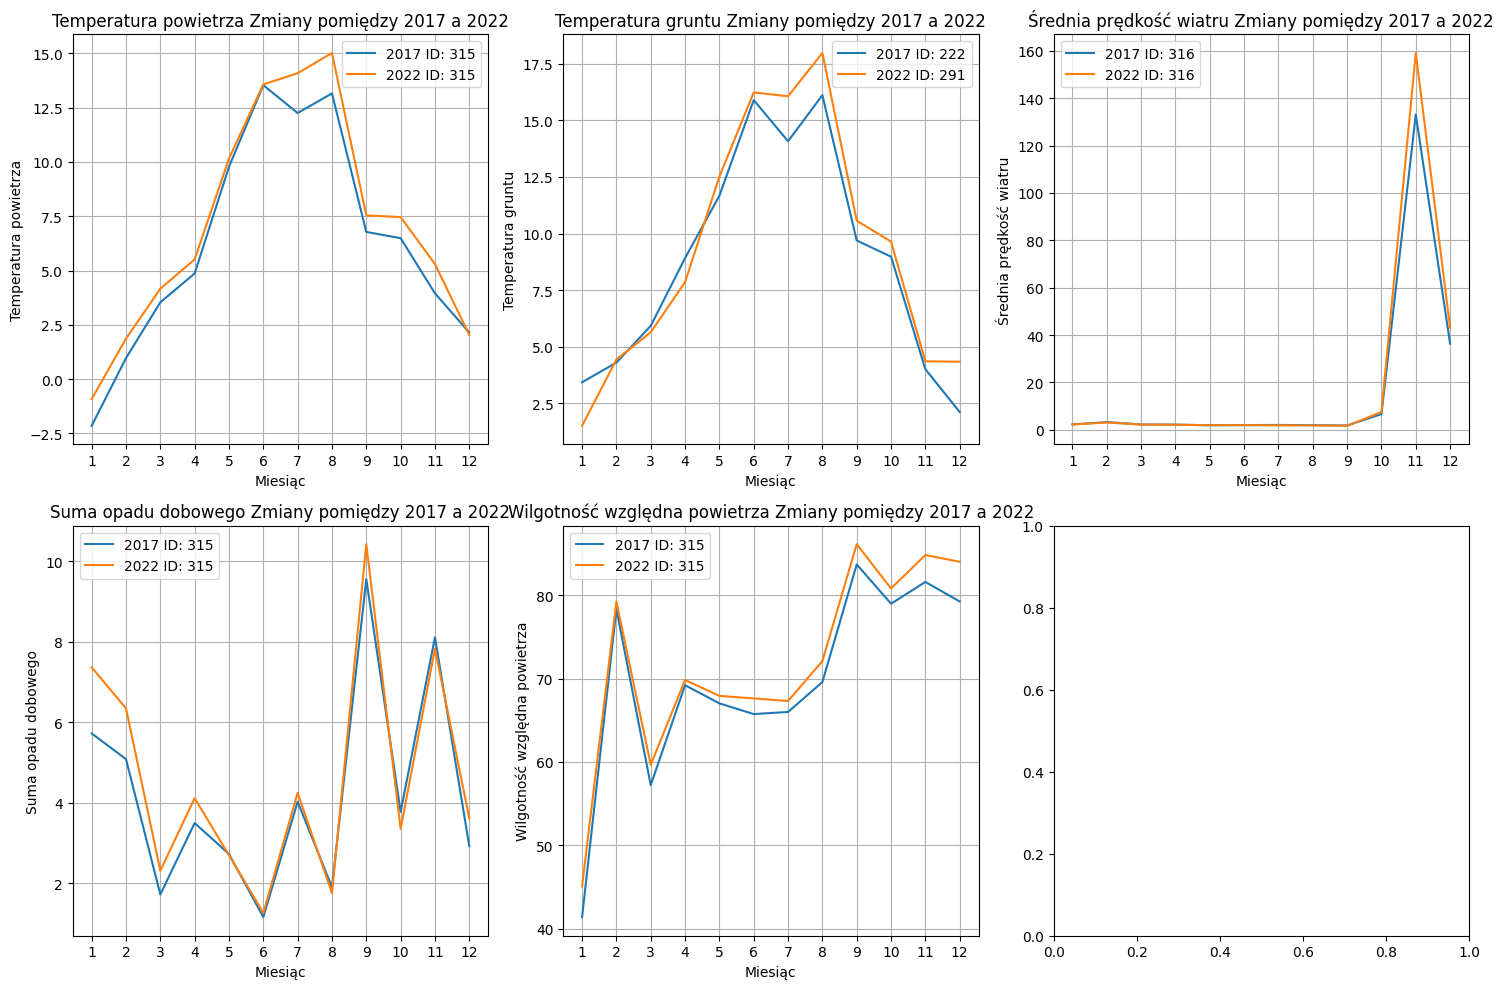

In [97]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(value_cols):
    station_id_2017 = selected_stations_2017[i]
    station_id_2022 = selected_stations_2022[i]
    
    data_2017 = filtered_data_2017[(filtered_data_2017['ID'] == station_id_2017)]
    data_2022 = filtered_data_2022[(filtered_data_2022['ID'] == station_id_2022)]
    
    ax = axes[i // 3, i % 3] 
    ax.plot(data_2017['Data_godzina'].dt.month, data_2017[col], label=f'2017 ID: {station_id_2017}')
    ax.plot(data_2022['Data_godzina'].dt.month, data_2022[col], label=f'2022 ID: {station_id_2022}')

    ax.set_xlabel('Miesiąc')
    ax.set_ylabel(col)
    ax.set_title(f'{col} Zmiany pomiędzy 2017 a 2022')
    ax.set_xticks(range(1, 13))

    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()



Jak można zauważyć, dane dotyczące średniej miesięcznej nie różnią się znacznie pomiędzy miesiącami. Wykresy dla temperatury powietrza, średniej prędkości wiatru i wilgotności powietrza są praktycznie identyczne. Jednakże wykres dla prędkości wiatru dla stacji 316 wydaje się być nieprawdopodobny, sugerując, że część danych mogła zniknąć. Dlatego druga i trzecia największa różnica dla wiatru zostały sprawdzone.

Rok: 2017
ID stacji: 532, Różnica w prędkości wiatru: 24.789481764928198
ID stacji: 11, Różnica w prędkości wiatru: 12.72140376984127
Rok: 2022
ID stacji: 532, Różnica w prędkości wiatru: 22.562006172839503
ID stacji: 11, Różnica w prędkości wiatru: 11.56693548387097


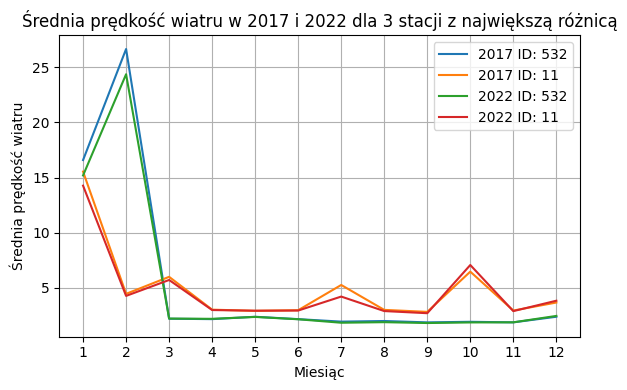

In [98]:
differences = {}

for year in [2017, 2022]:
    differences[year] = {}
    data_year = month_avg[month_avg['Data_godzina'].dt.year == year]
    value = 'Średnia prędkość wiatru'
    diff = data_year.groupby('ID')[value].agg(lambda x: x.max() - x.min()).nlargest(3)
    diff = diff.iloc[1:]

    for station_id, max_diff in diff.items():
        differences[year][station_id] = {'Wiatr różnica': max_diff}

plt.figure(figsize=(6, 4))

for year, year_diffs in differences.items():
    print(f"Rok: {year}")
    for station_id, details in year_diffs.items():
        print(f"ID stacji: {station_id}, Różnica w prędkości wiatru: {details['Wiatr różnica']}")
        data_year = month_avg[(month_avg['Data_godzina'].dt.year == year) & (month_avg['ID'] == station_id)]
        plt.plot(data_year['Data_godzina'].dt.month, data_year['Średnia prędkość wiatru'], label=f'{year} ID: {station_id}')

plt.xlabel('Miesiąc')
plt.ylabel('Średnia prędkość wiatru')
plt.title('Średnia prędkość wiatru w 2017 i 2022 dla 3 stacji z największą różnicą')
plt.xticks(range(1, 13)) 
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Sprawdzenie wartości dla stacji 316

In [99]:
group_316 = month_avg[month_avg['ID'] == 316]
print(group_316[['Średnia prędkość wiatru', 'Anomalia']])

                        Średnia prędkość wiatru  Anomalia
ID_stacji Data_godzina                                   
316       2017-01                      2.249256      0.12
          2017-02                      3.221452      0.12
          2017-03                      2.237277      0.09
          2017-04                      2.156790      0.02
          2017-05                      1.898214      0.12
          2017-06                      1.963966      0.01
          2017-07                      2.019595      0.10
          2017-08                      1.923986      0.03
          2017-09                      1.802894      0.00
          2017-10                      6.628604      0.09
          2017-11                    133.130930      0.14
          2017-12                     36.320495      0.07
          2022-01                      2.193280      0.15
          2022-02                      3.045672      0.15
          2022-03                      2.185618      0.01
          2022

Zauważono, że prędkość wiatru wyniosła prawie 160 w listopadzie, co sprawia, że wartość anomali wynosząca 0.14 w 2017 dla tej stacji ma sens. Niemniej jednak, w 2022 w tym samym miesiącu, dla podobnej prędkości wiatru, ta anomalia wyniosła jedynie 0.03.

#### Awaryjność stacji 

Wartości anomalii bts są liczone w średniej miesięcznej dlatego dalej dataframe ```month_avg``` będzie użyta

In [100]:
month_avg_2017 = month_avg[month_avg['Data_godzina'].dt.year == 2017]
month_avg_2022 = month_avg[month_avg['Data_godzina'].dt.year == 2022]

anomalia_2017 = np.nanmean(month_avg_2017['Anomalia'])
anomalia_2022 = np.nanmean(month_avg_2022['Anomalia'])

print(f"W roku 2017 średnia awyaryjność wszystkich stacji to: {anomalia_2017}, czyli: {round(365 * 24 * anomalia_2017, 2)} godzin, co stanowi {round(356*anomalia_2017, 2)} dni")
print(f"W roku 2022 średnia awyaryjność wszystkich stacji to: {anomalia_2022}, czyli: {round(365 * 24 * anomalia_2022, 2)} godzin, co stanowi {round(356*anomalia_2022, 2)} dni ")

anomalia_2017_orange = np.nanmean(month_avg_2017[month_avg_2017['siec'] == 'Orange']['Anomalia'])
anomalia_2022_orange = np.nanmean(month_avg_2022[month_avg_2022['siec'] == 'Orange']['Anomalia'])

print(f"Średnia anomial dla Oranga w 2017: {anomalia_2017_orange} czyli: {round(365 * 24 * anomalia_2017_orange, 2)} godzin, co stanowi {round(356*anomalia_2017_orange, 2)} dni ")
print(f"Średnia anomial dla Oranga w 2022: {anomalia_2022_orange} czyli: {round(365 * 24 * anomalia_2022_orange, 2)} godzin, co stanowi {round(356*anomalia_2022_orange, 2)} dni ")


W roku 2017 średnia awyaryjność wszystkich stacji to: 0.07474295190713102, czyli: 654.75 godzin, co stanowi 26.61 dni
W roku 2022 średnia awyaryjność wszystkich stacji to: 0.07316334991708127, czyli: 640.91 godzin, co stanowi 26.05 dni 
Średnia anomial dla Oranga w 2017: 0.07441780821917808 czyli: 651.9 godzin, co stanowi 26.49 dni 
Średnia anomial dla Oranga w 2022: 0.07345890410958905 czyli: 643.5 godzin, co stanowi 26.15 dni 


Miesięczne różnice pomiędzy stacjami

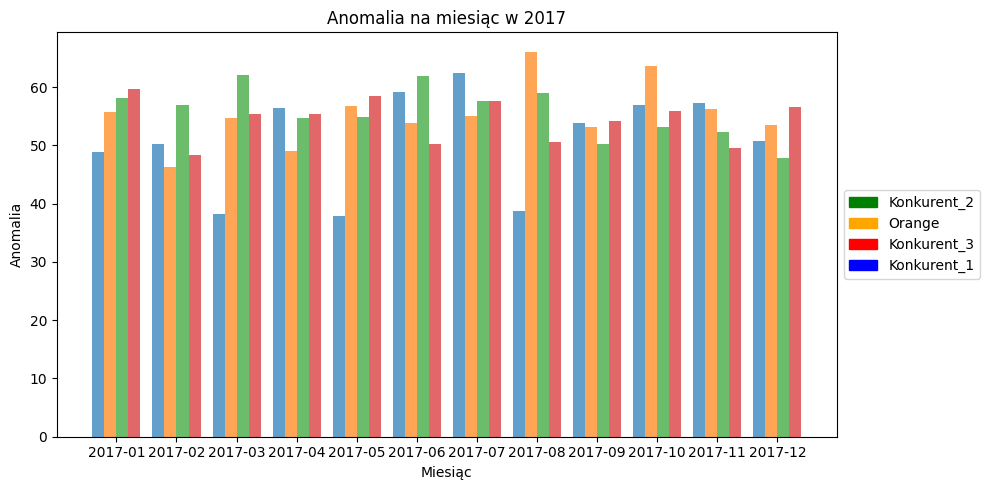

In [101]:
average_per_month_2017 = month_avg_2017.groupby(['siec', month_avg_2017['Data_godzina'].dt.to_period('M')]).mean()
average_per_month_2022 = month_avg_2022.groupby(['siec', month_avg_2022['Data_godzina'].dt.to_period('M')]).mean()

siec = bts['siec'].unique()

days_in_month_2017 = average_per_month_2017.index.get_level_values(1).map(lambda x: monthrange(x.year, x.month)[1])
average_per_month_2017['Anomalia godziny'] = days_in_month_2017 * 24 * average_per_month_2017['Anomalia']

days_in_month_2022 = average_per_month_2022.index.get_level_values(1).map(lambda x: monthrange(x.year, x.month)[1])
average_per_month_2022['Anomalia godziny'] = days_in_month_2022 * 24 * average_per_month_2022['Anomalia']


average_per_month_2017_siec = average_per_month_2017.loc[siec]
average_per_month_2022_siec = average_per_month_2022.loc[siec]

# Kod edytowany przy użyciu ChatGPT
fig, ax = plt.subplots(figsize=(10, 5))

num_networks = len(average_per_month_2017_siec.index.get_level_values(0).unique())
bar_width = 0.2
index = np.arange(len(average_per_month_2017_siec) // num_networks)  # Assuming same months for all networks

for i, (siec, data) in enumerate(average_per_month_2017_siec.groupby(level=0)):
    x = index + i * bar_width
    ax.bar(x, data['Anomalia godziny'], width=bar_width, label=siec, alpha=0.7)

ax.set_xlabel('Miesiąc')
ax.set_ylabel('Anomalia')
ax.set_title('Anomalia na miesiąc w 2017')
ax.set_xticks(index + ((num_networks - 1) * bar_width) / 2)
ax.set_xticklabels(average_per_month_2017_siec.index.get_level_values(1).unique())


color_dict = {'Konkurent_1': 'blue', 'Konkurent_2': 'green', 'Konkurent_3': 'red', 'Orange': 'orange'}
handles = [plt.Rectangle((0,0),1,1, color=color_dict[siec]) for siec in average_per_month_2017_siec.index.get_level_values(0).unique()]
ax.legend(handles, average_per_month_2017_siec.index.get_level_values(0).unique(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


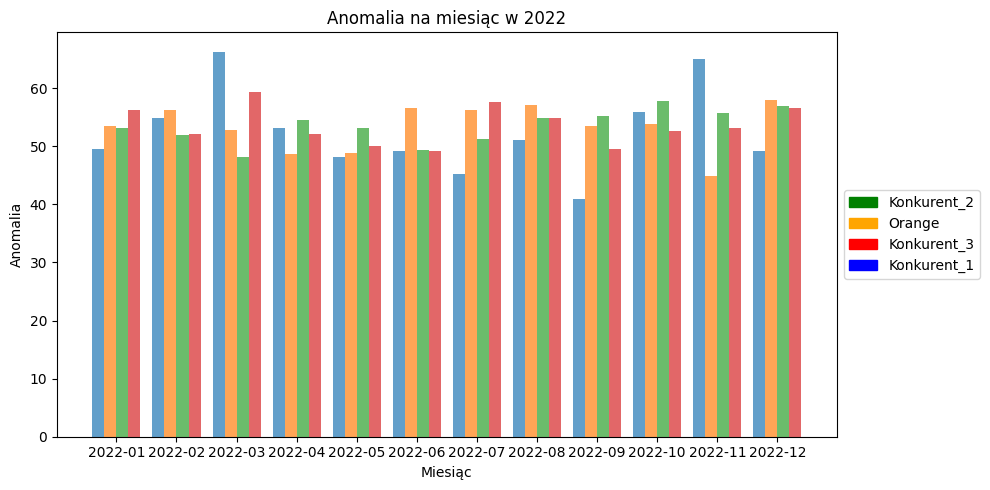

In [102]:
fig, ax = plt.subplots(figsize=(10, 5))
num_networks = len(average_per_month_2022_siec.index.get_level_values(0).unique())
bar_width = 0.2
index = np.arange(len(average_per_month_2022_siec) // num_networks)  # Assuming same months for all networks

for i, (siec, data) in enumerate(average_per_month_2022_siec.groupby(level=0)):
    x = index + i * bar_width
    ax.bar(x, data['Anomalia godziny'], width=bar_width, label=siec, alpha=0.7)

ax.set_xlabel('Miesiąc')
ax.set_ylabel('Anomalia')
ax.set_title('Anomalia na miesiąc w 2022')
ax.set_xticks(index + ((num_networks - 1) * bar_width) / 2)
ax.set_xticklabels(average_per_month_2022_siec.index.get_level_values(1).unique())


handles = [plt.Rectangle((0,0),1,1, color=color_dict[siec]) for siec in average_per_month_2022_siec.index.get_level_values(0).unique()]
ax.legend(handles, average_per_month_2022_siec.index.get_level_values(0).unique(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

#### Najbardzie awaryjne stacje dla Orange'a

In [103]:
orange_2017 = month_avg_2017[month_avg_2017['siec'] == 'Orange']
orange_2022 = month_avg_2022[month_avg_2022['siec'] == 'Orange']

top_10_orange_2017 = orange_2017.groupby('ID_stacji')['Anomalia'].mean().nlargest(10).reset_index()
top_10_orange_2022 = orange_2022.groupby('ID_stacji')['Anomalia'].mean().nlargest(10).reset_index()

top_10_orange_2017['Anomalia dzień'] = top_10_orange_2017['Anomalia'] * 365
top_10_orange_2022['Anomalia dzień'] = top_10_orange_2022['Anomalia'] * 365

print("10 najbardziej problematycznych stacji w 2017")
print(top_10_orange_2017[['ID_stacji', 'Anomalia dzień']])
print("\n10 najbardziej problematycznych stacji w 2022")
print(top_10_orange_2022[['ID_stacji', 'Anomalia dzień']])


10 najbardziej problematycznych stacji w 2017
   ID_stacji  Anomalia dzień
0        150       38.629167
1        554       38.629167
2        382       37.716667
3          5       35.283333
4         81       34.370833
5        163       34.066667
6        555       34.066667
7        512       33.762500
8        258       33.154167
9        136       33.154167

10 najbardziej problematycznych stacji w 2022
   ID_stacji  Anomalia dzień
0        111       38.020833
1        157       34.066667
2        161       32.545833
3        135       32.241667
4        268       32.241667
5        350       31.633333
6        383       31.633333
7        110       31.329167
8        204       31.329167
9        206       31.329167


Warto zauważyć, że żadna stacja nie pojawiła się w ekstremalnych warunkach pogodowych. Jednakże istnieje możliwość, że te stacje nie należały do Orange'a.

In [104]:
differences = {}

for year in [2017, 2022]:
    differences[year]={}
    data_year = month_avg[month_avg['Data_godzina'].dt.year == year]
    orange_data_year = data_year[data_year['siec'] == 'Orange']

    for value in value_cols:
        diff = orange_data_year.groupby('ID')[value].agg(lambda x: x.max() - x.min())
        if not diff.empty:
            max_station = diff.idxmax()
            max_diff = diff.max()
            differences[year][value] = {'Station_ID': max_station, 'Max_Difference': max_diff}
        else:
            differences[year][value] = {'Station_ID': None, 'Max_Difference': None}

for year, year_diffs in differences.items():
    print(f"Rok: {year}")
    for value, details in year_diffs.items():
        print(f"Parametr: {value}, ID stacji: {details['Station_ID']}, Największa różnica: {details['Max_Difference']}")

Rok: 2017
Parametr: Temperatura powietrza, ID stacji: 299, Największa różnica: 14.719846702452575
Parametr: Temperatura gruntu, ID stacji: 514, Największa różnica: 16.14713128306878
Parametr: Średnia prędkość wiatru, ID stacji: 2, Największa różnica: 3.7133865068691154
Parametr: Suma opadu dobowego, ID stacji: 133, Największa różnica: 7.178678678678679
Parametr: Wilgotność względna powietrza, ID stacji: 383, Największa różnica: 26.89880952380952
Rok: 2022
Parametr: Temperatura powietrza, ID stacji: 215, Największa różnica: 14.5831929125817
Parametr: Temperatura gruntu, ID stacji: 215, Największa różnica: 15.40535896650327
Parametr: Średnia prędkość wiatru, ID stacji: 2, Największa różnica: 3.402539580185727
Parametr: Suma opadu dobowego, ID stacji: 133, Największa różnica: 8.239784946236558
Parametr: Wilgotność względna powietrza, ID stacji: 161, Największa różnica: 27.484331375996746


Po odnalezieniu stacji z największymi różnicami, również żadna z nich nie jest w śród najbardziej psujących się

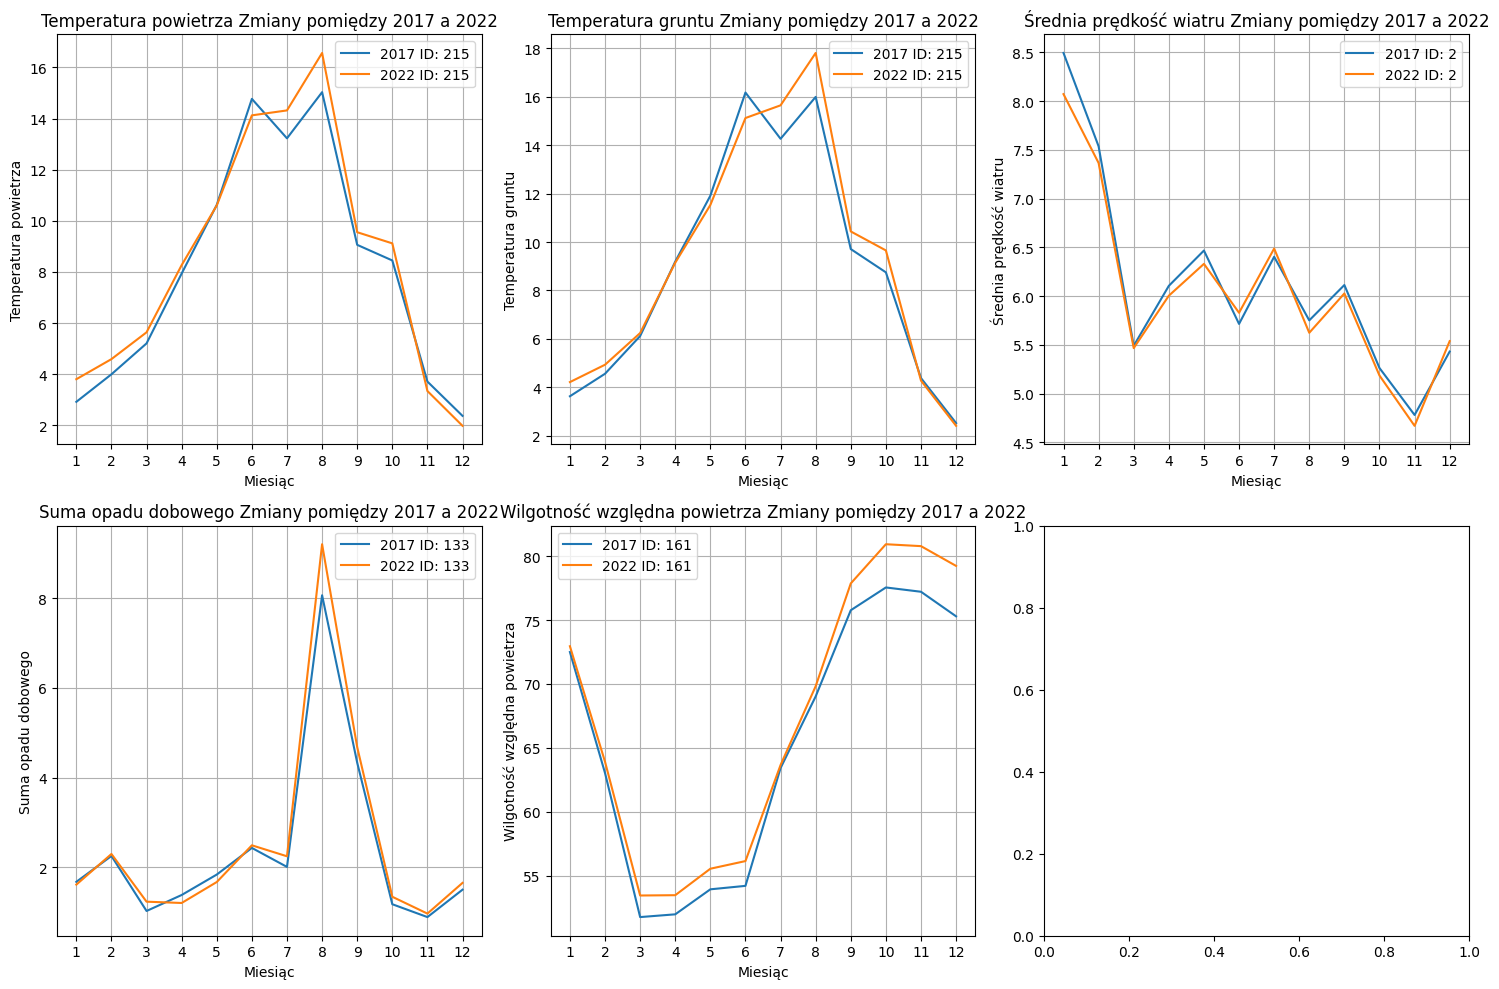

In [105]:
selected_stations_2017 = [215, 215, 2, 133, 161]
selected_stations_2022 = [215, 215, 2, 133, 161]

month_avg['Data_godzina'] = pd.to_datetime(month_avg['Data_godzina'])

filtered_data_2017 = month_avg[(month_avg['ID'].isin(selected_stations_2017)) & 
                               (month_avg['Data_godzina'].dt.year == 2017)]

filtered_data_2017 = filtered_data_2017[['ID', 'Data_godzina'] + value_cols]

filtered_data_2022 = month_avg[(month_avg['ID'].isin(selected_stations_2022)) & 
                               (month_avg['Data_godzina'].dt.year == 2022)]

filtered_data_2022 = filtered_data_2022[['ID', 'Data_godzina'] + value_cols]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(value_cols):
    station_id_2017 = selected_stations_2017[i]
    station_id_2022 = selected_stations_2022[i]
    
    data_2017 = filtered_data_2017[(filtered_data_2017['ID'] == station_id_2017)]
    data_2022 = filtered_data_2022[(filtered_data_2022['ID'] == station_id_2022)]
    
    ax = axes[i // 3, i % 3] 
    ax.plot(data_2017['Data_godzina'].dt.month, data_2017[col], label=f'2017 ID: {station_id_2017}')
    ax.plot(data_2022['Data_godzina'].dt.month, data_2022[col], label=f'2022 ID: {station_id_2022}')

    ax.set_xlabel('Miesiąc')
    ax.set_ylabel(col)
    ax.set_title(f'{col} Zmiany pomiędzy 2017 a 2022')
    ax.set_xticks(range(1, 13))

    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

In [106]:
differences = {}

for year in [2017, 2022]:
    differences[year] = {}
    data_year = month_avg[month_avg['Data_godzina'].dt.year == year]
    orange_data_year = data_year[data_year['siec'] == 'Orange']

    for value in value_cols:
        non_nan_data = orange_data_year[~orange_data_year[value].isnull()]
        if not non_nan_data.empty:
            max_month_idx = non_nan_data[value].idxmax()
            min_month_idx = non_nan_data[value].idxmin()

            max_month = non_nan_data.loc[max_month_idx, 'Data_godzina'].strftime('%B')
            min_month = non_nan_data.loc[min_month_idx, 'Data_godzina'].strftime('%B')

            max_station_id = non_nan_data.loc[max_month_idx, 'ID']
            min_station_id = non_nan_data.loc[min_month_idx, 'ID']

            max_value = non_nan_data.loc[max_month_idx, value]
            min_value = non_nan_data.loc[min_month_idx, value]

            differences[year][value] = {
                'Max_Month': max_month,
                'Max_Value': max_value,
                'Max_Station_ID': max_station_id,
                'Min_Month': min_month,
                'Min_Value': min_value,
                'Min_Station_ID': min_station_id
            }
        else:
            differences[year][value] = {
                'Max_Month': None,
                'Max_Value': None,
                'Max_Station_ID': None,
                'Min_Month': None,
                'Min_Value': None,
                'Min_Station_ID': None
            }

for year, year_diffs in differences.items():
    print(f"Rok: {year}")
    for value, details in year_diffs.items():
        if details['Max_Station_ID'] is not None and not pd.isnull(details['Max_Value']):
            print(f"Parameter: {value}")
            print(f"Miesiąc z największą wartością: {details['Max_Month']} | Stacja: {details['Max_Station_ID']} | Wartość: {details['Max_Value']}")
            print(f"Miesiąc z najmniejaszą wartością: {details['Min_Month']} | Stacja: {details['Min_Station_ID']} | Wartość: {details['Min_Value']}")


Rok: 2017
Parameter: Temperatura powietrza
Miesiąc z największą wartością: June | Stacja: 554 | Wartość: 17.541975308641977
Miesiąc z najmniejaszą wartością: January | Stacja: 135 | Wartość: -0.34985119047619045
Parameter: Temperatura gruntu
Miesiąc z największą wartością: June | Stacja: 514 | Wartość: 19.74884259259259
Miesiąc z najmniejaszą wartością: January | Stacja: 135 | Wartość: 0.6564732142857143
Parameter: Średnia prędkość wiatru
Miesiąc z największą wartością: January | Stacja: 2 | Wartość: 8.493293591654249
Miesiąc z najmniejaszą wartością: October | Stacja: 81 | Wartość: 1.1091435185185186
Parameter: Suma opadu dobowego
Miesiąc z największą wartością: August | Stacja: 133 | Wartość: 8.067567567567568
Miesiąc z najmniejaszą wartością: March | Stacja: 275 | Wartość: 0.5433333333333333
Parameter: Wilgotność względna powietrza
Miesiąc z największą wartością: September | Stacja: 299 | Wartość: 87.1665625
Miesiąc z najmniejaszą wartością: March | Stacja: 161 | Wartość: 51.7600520

Z 10 stacji, 2 z najbardziej skrajnymi wartościami znalazły się na liście 10 najbardziej awaryjnych stacji - jedna w 2017 roku, a druga w 2022. Dlatego można przypuszczać, że warunki pogodowe przyczyniają się do awaryjności stacji.

### Orange a konkurenci 

Mapa stacji używając Google Earth Engine

Poniższy fragment kodu wymaga posiadania konta na Google Earth Engine. Rejestracja jest bezpłatna i szybka. Po zarejestrowaniu się konieczne będzie zalogowanie się na konto przy użyciu linku wygenerowanego poniżej. Następnie otrzymany kod należy skopiować i wkleić do odpowiedniego pola.

In [107]:
ee.Authenticate()

Enter verification code:  4/1AfJohXnzNd0OU7KNRvnmoaa-V1R2fAjPOuf6595He5aVP-lxOaBPQLIQaU4



Successfully saved authorization token.


In [108]:
try:
    # Initialize the library.
    ee.Initialize()
    print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
    print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

Google Earth Engine has initialized successfully!


W tym fragmencie zadania wykorzystane będą tylko dane, które zawierają wszystkie elementy, czyli rzędy, w których nie występuje żaden NaN. Poprzez tę operację stracimy niektóre informacje, ale liczba pozostałych rzędów będzie wystarczająca, aby wyłonić zależności.

In [109]:
rows_before_drop = month_avg.shape[0]
columns_to_drop = ['Wilgotność względna powietrza', 'Temperatura powietrza', 
                   'Średnia prędkość wiatru', 'Temperatura gruntu', 
                   'Suma opadu dobowego', 'Nazwa']

month_clean = month_avg.drop(columns=columns_to_drop, axis=1)
month_clean.dropna(how='any', inplace = True)
rows_after_drop = month_clean.shape[0]

print(f"Liczba rzędów z NaN: {rows_before_drop}")
print(f"Liczba rzędów bez NaN: {rows_after_drop}")
column_names = month_clean.columns.tolist()
print(column_names)

print(np.sort(month_clean['Anomalia'].unique()))
print(month_clean['standard'].unique())
month_clean.tail()

Liczba rzędów z NaN: 13080
Liczba rzędów bez NaN: 4824
['ID', 'Data_godzina', 'Szerokość geograficzna', 'Długość geograficzna', 'bts_id', 'siec', 'standard', 'Anomalia']
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15]
['    IOT' 'GSM UMTS   ' '  LTE  ' '   5G ' 'GSM   5G ' ' UMTS LTE 5G '
 ' UMTS LTE  ' ' UMTS   ' 'GSM UMTS LTE  ' 'GSM  LTE  ' '  LTE  IOT'
 '  LTE 5G ' 'GSM UMTS LTE 5G ' 'GSM    ' 'GSM UMTS   IOT' 'GSM  LTE  IOT'
 ' UMTS   IOT' 'GSM UMTS  5G ' 'GSM   5G IOT' 'GSM  LTE 5G ' 'GSM    IOT'
 ' UMTS  5G ' '   5G IOT' '  LTE 5G IOT' ' UMTS  5G IOT'
 'GSM UMTS LTE  IOT']


ID Data_godzina  Szerokość geograficzna  \
ID_stacji Data_godzina                                             
556       2022-08       556   2022-08-02               53.593889   
          2022-09       556   2022-09-02               53.593889   
          2022-10       556   2022-10-02               53.593889   
          2022-11       556   2022-11-02               53.593889   
          2022-12       556   2022-12-02               53.593889   

                        Długość geograficzna  bts_id    siec standard  \
ID_stacji Data_godzina                                                  
556       2022-08                  14.888333  1253.0  Orange    LTE     
          2022-09                  14.888333  1253.0  Orange    LTE     
          2022-10                  14.888333  1253.0  Orange    LTE     
          2022-11                  14.888333  1253.0  Orange    LTE     
          2022-12                  14.888333  1253.0  Orange    LTE     

                        Anomalia  
ID_stacji Data_godzina            
556       2022-08           0.10  
          2022-09           0.07  
          2022-10           0.13  
          2022-11           0.04  
          2022-12           0.09

Podzielenie kolumny ```standard``` na 5 części ułatwi wizualizację. Standrady są ustawione od najgorszego do najlepszego: IoT jako najgorszy - 5G jako najlepszy.

In [110]:
# Kod edytowany przy użyciu ChatGPT
standard_dict = {
    'IOT': 'IOT',
    'GSM': 'GSM',
    'UMTS': 'UMTS',
    'LTE': 'LTE',
    '5G': '5G'
}
for standard, string in standard_dict.items():
    month_clean[standard] = month_clean['standard'].str.contains(string.strip())

# Checking the newly created columns
month_clean.tail()

ID Data_godzina  Szerokość geograficzna  \
ID_stacji Data_godzina                                             
556       2022-08       556   2022-08-02               53.593889   
          2022-09       556   2022-09-02               53.593889   
          2022-10       556   2022-10-02               53.593889   
          2022-11       556   2022-11-02               53.593889   
          2022-12       556   2022-12-02               53.593889   

                        Długość geograficzna  bts_id    siec standard  \
ID_stacji Data_godzina                                                  
556       2022-08                  14.888333  1253.0  Orange    LTE     
          2022-09                  14.888333  1253.0  Orange    LTE     
          2022-10                  14.888333  1253.0  Orange    LTE     
          2022-11                  14.888333  1253.0  Orange    LTE     
          2022-12                  14.888333  1253.0  Orange    LTE     

                        Anomalia    IOT    GSM   UMTS   LTE     5G  
ID_stacji Data_godzina                                              
556       2022-08           0.10  False  False  False  True  False  
          2022-09           0.07  False  False  False  True  False  
          2022-10           0.13  False  False  False  True  False  
          2022-11           0.04  False  False  False  True  False  
          2022-12           0.09  False  False  False  True  False

Po wyświetelniu Mapy po prawej stronie ekranu jest menu z warstwami które można dowolnie aktywować i dezaktywować

In [111]:
features_2017_orange = []
features_2017_konkurenci = []
features_2022_orange = []
features_2022_konkurenci = []


for index, row in month_clean.iterrows():
    point = ee.Geometry.Point([row['Długość geograficzna'], row['Szerokość geograficzna']])
    feature = ee.Feature(
        point, {
            'Anomalia': row['Anomalia'],
            'siec': row['siec'],
            'ID_stacji': row['ID'],
            'Data_godzina': row['Data_godzina'],
            'bts_id': row['bts_id'],
            'IOT': row['IOT'],
            'GSM': row['GSM'],
            'UMTS': row['UMTS'],
            'LTE': row['LTE'],
            '5G': row['5G'],
        }
    )
    if row['Data_godzina'].year == 2017:
        if row['siec'] == 'Orange':
            features_2017_orange.append(feature)
        else:
            features_2017_konkurenci.append(feature)
    elif row['Data_godzina'].year == 2022:
        if row['siec'] == 'Orange':
            features_2022_orange.append(feature)
        else:
            features_2022_konkurenci.append(feature)


feature_collection_2017_orange = ee.FeatureCollection(features_2017_orange)
feature_collection_2017_konkurenci = ee.FeatureCollection(features_2017_konkurenci)

feature_collection_2022_orange = ee.FeatureCollection(features_2022_orange)
feature_collection_2022_konkurenci = ee.FeatureCollection(features_2022_konkurenci)


Map = geemap.Map(center=[52.0, 19.0], zoom=6)

# Create styles for Orange and other stations for 2017
orange_style = {'color': 'orange'}
other_stations = {'color': 'blue'}

# Add layers for 2017
Map.addLayer(feature_collection_2017_orange, orange_style, 'Stacje Orange 2017')
Map.addLayer(feature_collection_2017_konkurenci, other_stations, 'Inne stacje 2017')

Map.addLayer(feature_collection_2022_orange, orange_style, 'Stacje Orange 2022')
Map.addLayer(feature_collection_2022_konkurenci, other_stations, 'Inne stacje 2022')

Map.addLayerControl()
Map

Map(center=[52.0, 19.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

In [112]:
# Kod edytowany przy użyciu ChatGPT
style_settings = {
    'IOT': {'color': 'red', 'radius': 500},
    'GSM': {'color': 'pink', 'radius': 450},
    'UMTS': {'color': 'green', 'radius': 350},
    'LTE': {'color': 'black', 'radius': 250},
    '5G': {'color': 'purple', 'radius': 130}
}

# Create FeatureCollections for each standard and each year
feature_collections = {}
years = ['2017', '2022']
standards = ['IOT', 'GSM', 'UMTS', 'LTE', '5G']

for year in years:
    for standard in standards:
        features = []
        for index, row in month_clean.iterrows():
            if row['Data_godzina'].year == int(year) and row['siec'] == 'Orange' and row[standard]:
                point = ee.Geometry.Point([row['Długość geograficzna'], row['Szerokość geograficzna']])
                feature = ee.Feature(
                    point, {
                        'Anomalia': row['Anomalia'],
                        'siec': row['siec'],
                        'ID_stacji': row['ID'],
                        'Data_godzina': row['Data_godzina'],
                        'bts_id': row['bts_id']
                    }
                )
                features.append(feature)
        feature_collections[f'{standard}_{year}'] = ee.FeatureCollection(features)

# Add layers for each standard and each year with different styles
for key, value in feature_collections.items():
    standard, year = key.split('_')
    style = {
        'color': style_settings[standard]['color'],
        'radius': style_settings[standard]['radius']
    }
    layer_name = f'{standard} Stacje Orange {year}'
    Map.addLayer(value, style, layer_name)

Map.addLayerControl()
Map

Map(center=[52.0, 19.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

Za pomocą geopandas:
    
Shapefile do mapy polski można pobrać z https://data.humdata.org/dataset/cod-ab-pol?

jest to pierwszy możliwy plik

I dodać jako zip do tego folderu w któym znajduje się notebook, a następnie:


In [ ]:
!unzip pol_adm_gov_v02_20220414_shp

In [114]:
!mv pol_adm_gov_v02_20220414_SHP map

Mapa Polski pokazująca potencjalny zasięg masztów Orange'a

<Figure size 800x600 with 0 Axes>

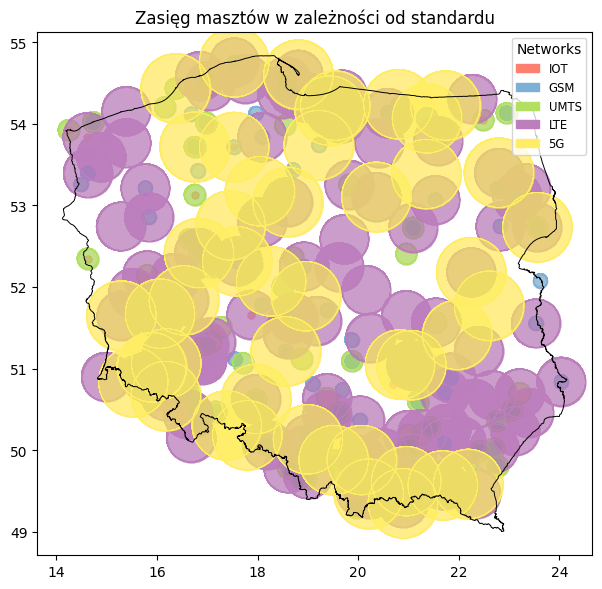

In [115]:
plt.figure(figsize=(8, 6))

poland = gpd.read_file('map/pol_admbnda_adm0_gov_v02_20220414.shp')

plt.figure(figsize=(8, 6))

standards = ['IOT', 'GSM', 'UMTS', 'LTE', '5G']
colors = ['#fd7f6f', '#7eb0d5', '#b2e061', '#bd7ebe', '#ffee65']
# promień w km na podstawie zasięgu danego standardu
radius = [5, 10, 15, 35, 50] 

for i, standard in enumerate(standards):
    subset = month_clean[month_clean[standard]]
    if i == 0:
        plt.scatter(subset['Długość geograficzna'], subset['Szerokość geograficzna'], s=(radius[i] ** 2),
                c=colors[i], alpha=0.05, edgecolor = colors[i], linewidths=1, label=standard)
    else:
        plt.scatter(subset['Długość geograficzna'], subset['Szerokość geograficzna'], s=(radius[i] ** 2),
                c='none', alpha=1, edgecolor = colors[i], linewidths=0.5)
        plt.scatter(subset['Długość geograficzna'], subset['Szerokość geograficzna'], s=(radius[i] ** 2),
                c=colors[i], alpha=0.05, edgecolor = colors[i], linewidths=1)

poland.boundary.plot(ax=plt.gca(), linewidth=0.7, color='black')

plt.title('Zasięg masztów w zależności od standardu')

legend_handles = []
for i, standard in enumerate(standards):
    circle = mpatches.Circle((0, 0), radius=15, edgecolor=colors[i], facecolor=colors[i], label=standard)
    legend_handles.append(circle)
plt.legend(handles=legend_handles, loc='upper right', fontsize='small', title='Networks')

plt.tight_layout()
plt.show()

Patrząc na opisane wcześniej zasięgi, zauważalne jest, że istnieją miejsca w Polsce, gdzie zasięg Orange'a nie jest dostępny

Text(0.5, 1.0, 'Konkurencja 2022')

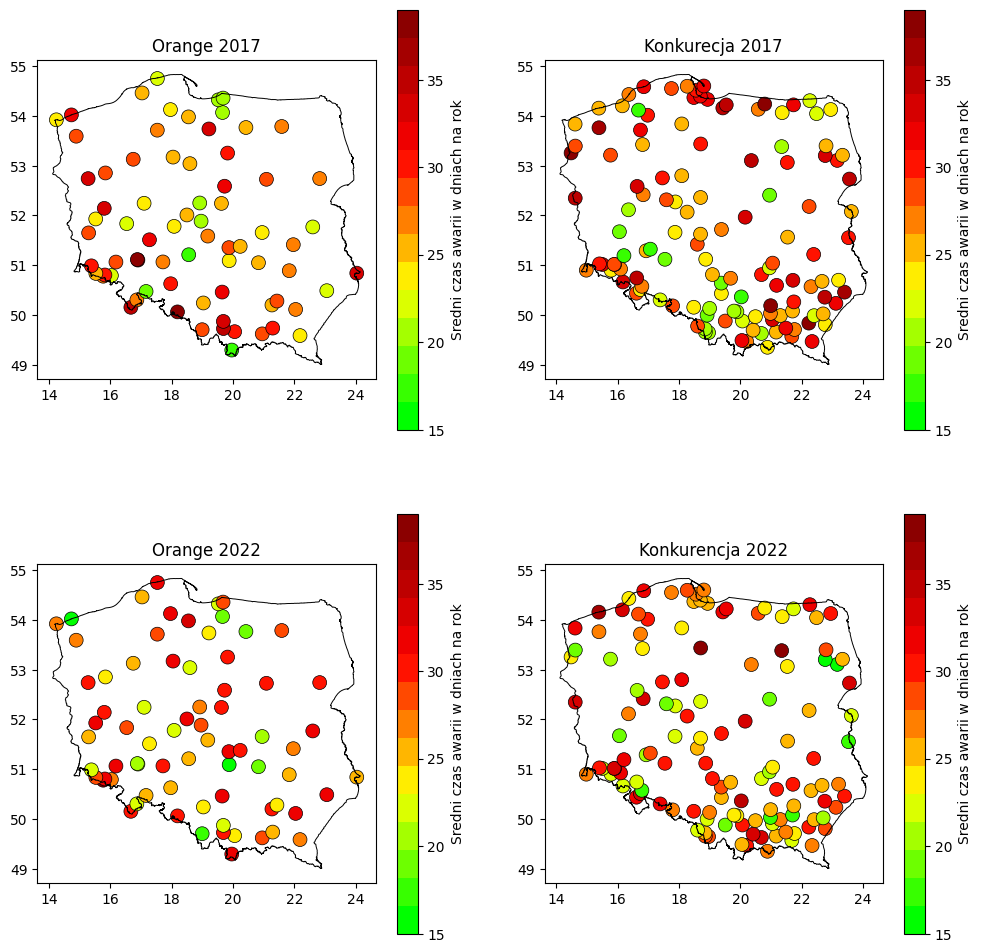

In [116]:
orange_2017 = month_clean[(month_clean['Data_godzina'].dt.year == 2017) & (month_clean['siec'] == 'Orange')]
non_orange_2017 = month_clean[(month_clean['Data_godzina'].dt.year == 2017) & (month_clean['siec'] != 'Orange')]

orange_2022 = month_clean[(month_clean['Data_godzina'].dt.year == 2022) & (month_clean['siec'] == 'Orange')]
non_orange_2022 = month_clean[(month_clean['Data_godzina'].dt.year == 2022) & (month_clean['siec'] != 'Orange')]

# Calculating averages
avg_orange_2017 = orange_2017.groupby(['Szerokość geograficzna', 'Długość geograficzna'])['Anomalia'].mean().reset_index()
avg_orange_2017['Anomalia_dni'] = avg_orange_2017['Anomalia'] * 365

avg_non_orange_2017 = non_orange_2017.groupby(['Szerokość geograficzna', 'Długość geograficzna'])['Anomalia'].mean().reset_index()
avg_non_orange_2017['Anomalia_dni'] = avg_non_orange_2017['Anomalia'] * 365

avg_orange_2022 = orange_2022.groupby(['Szerokość geograficzna', 'Długość geograficzna'])['Anomalia'].mean().reset_index()
avg_orange_2022['Anomalia_dni'] = avg_orange_2022['Anomalia'] * 365

avg_non_orange_2022 = non_orange_2022.groupby(['Szerokość geograficzna', 'Długość geograficzna'])['Anomalia'].mean().reset_index()
avg_non_orange_2022['Anomalia_dni'] = avg_non_orange_2022['Anomalia'] * 365

colors = ['#00FF00', '#FFFF00', '#FF0000', '#8B0000']

# Plotting
cmap = LinearSegmentedColormap.from_list('anomaly_color', colors, N=15)

plt.figure(figsize=(12, 12))

# Orange 2017
plt.subplot(2, 2, 1)
poland.boundary.plot(ax=plt.gca(), linewidth=0.7, color='black')
plt.scatter(avg_orange_2017['Długość geograficzna'], avg_orange_2017['Szerokość geograficzna'],
            c=avg_orange_2017['Anomalia_dni'], cmap=cmap, vmin=15, vmax=39, s=100, edgecolors='black', linewidths=0.5)
plt.colorbar(label='Sredni czas awarii w dniach na rok')
plt.title('Orange 2017')

# Non-Orange 2017
plt.subplot(2, 2, 2)
poland.boundary.plot(ax=plt.gca(), linewidth=0.7, color='black')
plt.scatter(avg_non_orange_2017['Długość geograficzna'], avg_non_orange_2017['Szerokość geograficzna'],
            c=avg_non_orange_2017['Anomalia_dni'], cmap=cmap, vmin=15, vmax=39, s=100, edgecolors='black', linewidths=0.5)
plt.colorbar(label='Sredni czas awarii w dniach na rok')
plt.title('Konkurecja 2017')

# Orange 2022
plt.subplot(2, 2, 3)
poland.boundary.plot(ax=plt.gca(), linewidth=0.7, color='black')
plt.scatter(avg_orange_2022['Długość geograficzna'], avg_orange_2022['Szerokość geograficzna'],
            c=avg_orange_2022['Anomalia_dni'], cmap=cmap, vmin=15, vmax=39, s=100, edgecolors='black', linewidths=0.5)
plt.colorbar(label='Sredni czas awarii w dniach na rok')
plt.title('Orange 2022')

# Non-Orange 2022
plt.subplot(2, 2, 4)
poland.boundary.plot(ax=plt.gca(), linewidth=0.7, color='black')
plt.scatter(avg_non_orange_2022['Długość geograficzna'], avg_non_orange_2022['Szerokość geograficzna'],
            c=avg_non_orange_2022['Anomalia_dni'], cmap=cmap, vmin=15, vmax=39, s=100, edgecolors='black', linewidths=0.5)
plt.colorbar(label='Sredni czas awarii w dniach na rok')
plt.title('Konkurencja 2022')


Widoczne są zmiany w ilości obserwowanych anomalii na stacjach w ciągu pięciu lat. Lokalizacje stacji z najlepszym i najgorszym zasięgiem również się zmieniły. Jednakże, jak można zauważyć z danych z 2022 roku, środek Polski obfituje w stacje z dużą ilością anomalii, podczas gdy pięć lat wcześniej było to południe kraju.

W 2017 roku konkurencja miała lepiej działające maszty na południu Polski, ale w 2022 roku również nie miała sprawnie działających stacji w centrum Polski.

Aby zobaczyć to w praktyce, przygotowano poniższą wizualizację: mapa Polski została podzielona na kwadraty o wymiarach około 60 km x 60 km. Dla każdego kwadratu obliczono średnią liczbę anomalii rocznie dla Orange i Konkurencji. Gdzie Orange miało mniejszą średnią anomalię, kwadrat jest zielony, w przeciwnym razie czerwony. Biały kwadrat oznacza, że w tym obszarze nie było żadnych stacji.

Z wyników widać, że Orange jest lepszy od konkurencji w około 20% obszarów. Ta wartość wzrosła o ponad 1 punkt procentowy z 2017 do 2022 roku. Wynik 20% oznacza, że istnieje konkurencja, która radzi sobie lepiej od Orange (na 4 sieci wynik musiałby wynosić minimum powyżej 25%)."


Przewaga Orange 2017: 21.18%
Przewaga Orange 2022: 22.35%


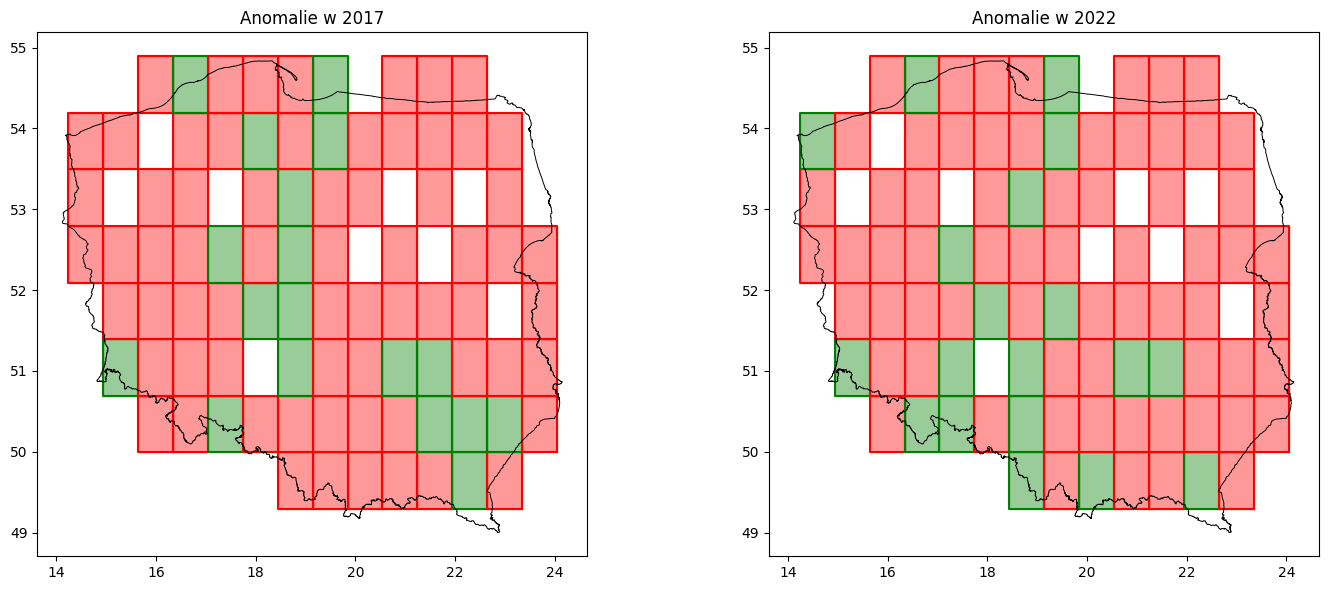

In [117]:
years = [2017, 2022]
data_frames = {}
percentages = {}

for year in years:
    data_year = month_clean[month_clean['Data_godzina'].dt.year == year]
    data_year = data_year.groupby(['Szerokość geograficzna', 'Długość geograficzna', 'siec'])['Anomalia'].mean().reset_index()
    gdf_year = gpd.GeoDataFrame(data_year, geometry=gpd.points_from_xy(data_year['Długość geograficzna'], data_year['Szerokość geograficzna']))
    data_frames[year] = gdf_year

fig, axes = plt.subplots(1, 2, figsize=(15, 6))


for idx, (year, gdf) in enumerate(data_frames.items()):
    poland_bounds_year = gdf.total_bounds
    grid_size = 0.7 
    
    xmin, ymin, xmax, ymax = poland_bounds_year
    x_steps = int(np.ceil((xmax - xmin) / grid_size))
    y_steps = int(np.ceil((ymax - ymin) / grid_size))

    grid = []
    for i in range(x_steps):
        for j in range(y_steps):
            square = box(xmin + i * grid_size, ymin + j * grid_size, xmin + (i + 1) * grid_size, ymin + (j + 1) * grid_size)
            grid.append(square)

    def color_square(square, color):
        axes[idx].plot(*square.exterior.xy, color=color)
        axes[idx].fill(*square.exterior.xy, color=color, alpha=0.4)
        
    count_negative_diff = 0 
    stations = 0

    for square in grid:
        stations_in_square = gdf[gdf.geometry.within(square)]
        if len(stations_in_square) != 0:
            stations += 1
            orange_avg = stations_in_square[stations_in_square['siec'] == 'Orange']['Anomalia'].mean()
            other_avg = stations_in_square[stations_in_square['siec'] != 'Orange']['Anomalia'].mean()

            diff = orange_avg - other_avg

            if diff < 0:
                color_square(square, color='green')
                count_negative_diff += 1
            else:
                color_square(square, color='red')

    axes[idx].set_title(f'Anomalie w {year}')
    poland.boundary.plot(ax=axes[idx], linewidth=0.7, color='black')
    percentages[year] = (count_negative_diff / stations) * 100

    print(f'Przewaga Orange {year}: {percentages[year]:.2f}%')

plt.tight_layout()
plt.show()


## Machine Learning

### Clustering

Korzystając z danych pogodowych, celem algorytmu będzie znalezienie jednego z trzech clusterów. Teoretyczny założenie jest takie, że istnieje możliwość, iż clustery w jakiś sposób korelują z anomalią w danym miesiącu.

In [118]:
rows_before_drop = month_avg.shape[0]

month_full_clean = month_avg.dropna(how='any').copy()
rows_after_drop = month_full_clean.shape[0]

print(f"Liczba rzędów z NaN: {rows_before_drop}")
print(f"Liczba rzędów bez NaN: {rows_after_drop}")
month_full_clean.head()

Liczba rzędów z NaN: 13080
Liczba rzędów bez NaN: 2688


ID Data_godzina  Wilgotność względna powietrza  \
ID_stacji Data_godzina                                                   
2         2017-01        2   2017-01-01                      84.137854   
          2017-02        2   2017-02-01                      77.541667   
          2017-03        2   2017-03-01                      72.957589   
          2017-04        2   2017-04-01                      80.199846   
          2017-05        2   2017-05-01                      74.244792   

                        Suma opadu dobowego  Temperatura gruntu  \
ID_stacji Data_godzina                                            
2         2017-01                  1.182143            5.728423   
          2017-02                  3.992857            6.894083   
          2017-03                  1.176786            7.779985   
          2017-04                  1.474074           10.522377   
          2017-05                  2.501786           14.423810   

                        Średnia prędkość wiatru  Temperatura powietrza  \
ID_stacji Data_godzina                                                   
2         2017-01                      8.493294               4.803423   
          2017-02                      7.535559               6.133556   
          2017-03                      5.489286               6.731548   
          2017-04                      6.104552               8.333179   
          2017-05                      6.466667              12.208482   

                          Nazwa  Szerokość geograficzna  Długość geograficzna  \
ID_stacji Data_godzina                                                          
2         2017-01       DZIWNÓW               54.022222             14.731667   
          2017-02       DZIWNÓW               54.022222             14.731667   
          2017-03       DZIWNÓW               54.022222             14.731667   
          2017-04       DZIWNÓW               54.022222             14.731667   
          2017-05       DZIWNÓW               54.022222             14.731667   

                        bts_id    siec     standard  Anomalia  
ID_stacji Data_godzina                                         
2         2017-01        100.0  Orange  GSM UMTS         0.04  
          2017-02        100.0  Orange  GSM UMTS         0.15  
          2017-03        100.0  Orange  GSM UMTS         0.04  
          2017-04        100.0  Orange  GSM UMTS         0.13  
          2017-05        100.0  Orange  GSM UMTS         0.12

Clustering dla wszystkich kolumn pogodowych dla 5 clusterów. Następnie wyniki zostają porównane z wartościami anomalii, które też są podzielone na 5 koszy. Jak widać po wykresach, żaden cluster nie jest homogeniczny. Nawet po zmianie wartości dla clusterów i ich liczby ten wynik się nie poprawia. Dlatego można zauważyć, że clusterowanie nie jest odpowiednim sposobem by przewidzieć poziom anomalii na podstawie średnich pogodowych.

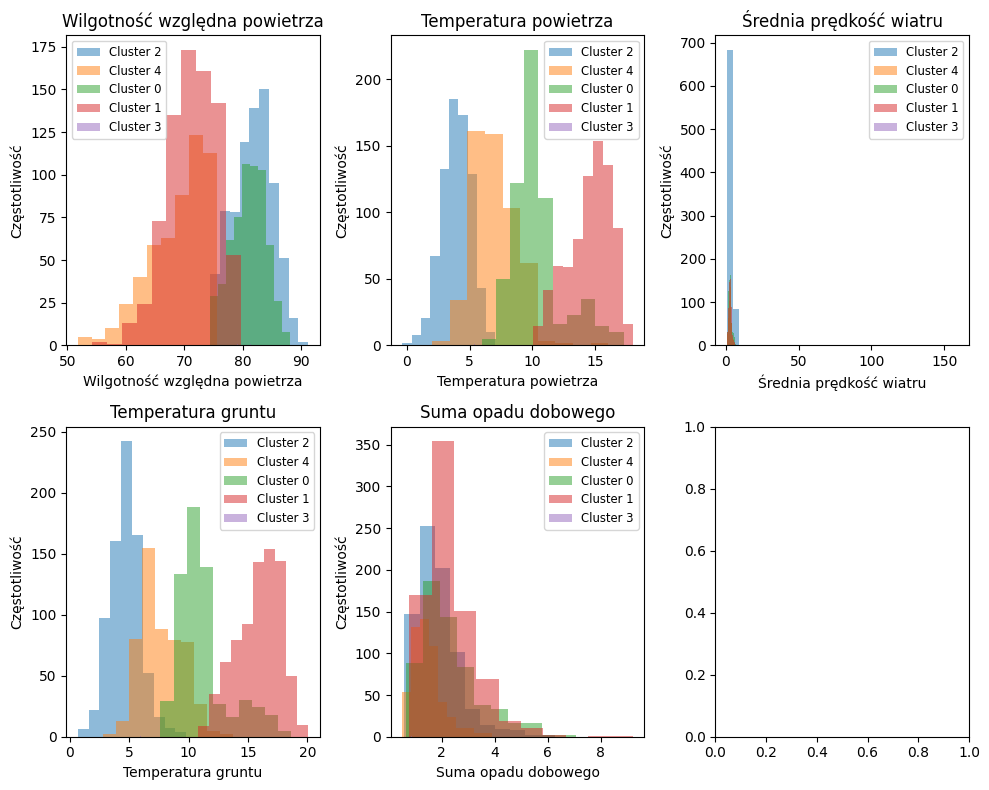

In [119]:
columns_for_clustering = ['Wilgotność względna powietrza', 'Temperatura powietrza', 'Średnia prędkość wiatru', 'Temperatura gruntu', 'Suma opadu dobowego']

data_for_clustering = month_full_clean[columns_for_clustering]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

kmeans = KMeans(n_clusters=5, random_state=42)
month_full_clean['Cluster'] = kmeans.fit_predict(data_for_clustering)

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, column in enumerate(columns_for_clustering):
    row = i // 3
    col = i % 3
    for cluster in month_full_clean['Cluster'].unique():
        cluster_data = month_full_clean[month_full_clean['Cluster'] == cluster]
        axs[row, col].hist(cluster_data[column], alpha=0.5, label=f'Cluster {cluster}')
        axs[row, col].set_xlabel(column)
        axs[row, col].set_ylabel('Częstotliwość')
        axs[row, col].legend(fontsize='small')
        axs[row, col].title.set_fontsize(10)
        axs[row, col].set_title(f'{column}')

# Adjust layout
plt.tight_layout()
plt.show()
                                       
                                       

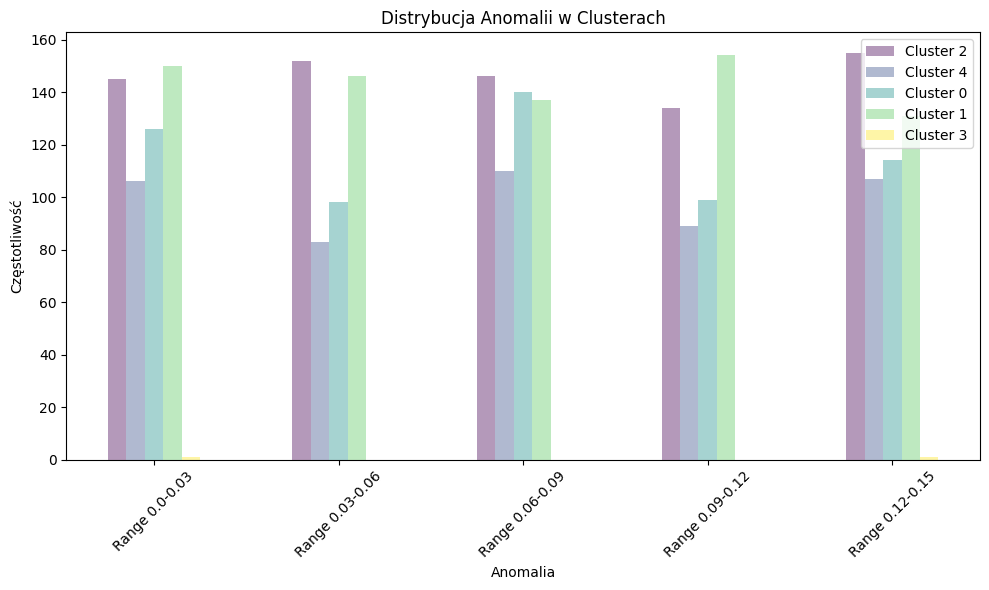

In [120]:
bins = [0.0, 0.03, 0.06, 0.09, 0.12, 0.15]
month_full_clean['Anomalia_Range'] = pd.cut(month_full_clean['Anomalia'], bins=bins)

num_clusters = len(bins) - 1
colors = plt.cm.viridis(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(10, 6))

bar_width = 0.1 
cluster_numbers = month_full_clean['Cluster'].unique()

for i, cluster in enumerate(cluster_numbers):
    ax = plt.subplot(111)
    cluster_data = month_full_clean[month_full_clean['Cluster'] == cluster]
    bin_counts = cluster_data['Anomalia_Range'].value_counts().sort_index()
    bar_position = np.arange(len(bins) - 1) + i * bar_width
    
    ax.bar(bar_position, bin_counts, width=bar_width, alpha=0.4, label=f'Cluster {cluster}', color=colors[i])

plt.title('Distrybucja Anomalii w Clusterach')
plt.xlabel('Anomalia')
plt.ylabel('Częstotliwość')
plt.legend()
plt.xticks(np.arange(len(bins) - 1) + bar_width * ((len(cluster_numbers) - 1) / 2), [f'Range {bins[i]}-{bins[i+1]}' for i in range(len(bins) - 1)], rotation=45)
plt.tight_layout()
plt.show()




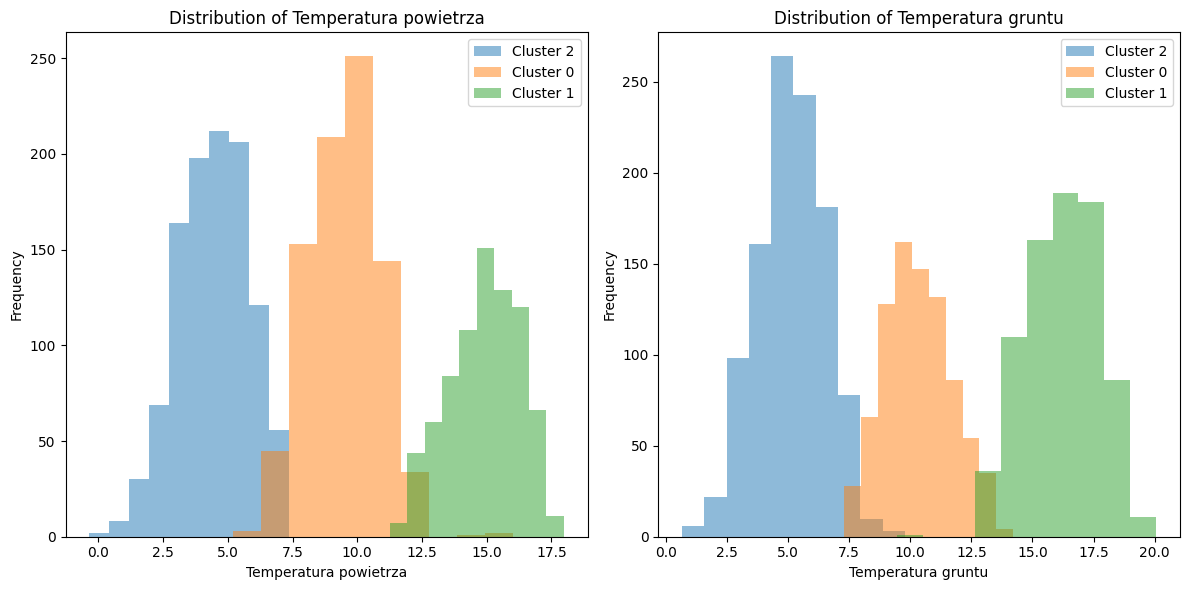

In [121]:
columns_for_clustering = ['Temperatura powietrza', 'Temperatura gruntu']
data_for_clustering = month_full_clean[columns_for_clustering]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

kmeans = KMeans(n_clusters=3, random_state=42)
month_full_clean['Cluster'] = kmeans.fit_predict(scaled_data)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, column in enumerate(columns_for_clustering):
    for cluster in month_full_clean['Cluster'].unique():
        cluster_data = month_full_clean[month_full_clean['Cluster'] == cluster]
        axs[i].hist(cluster_data[column], alpha=0.5, label=f'Cluster {cluster}')
        axs[i].set_xlabel(column)
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
        axs[i].set_title(f'Distribution of {column}')
        axs[i].title.set_fontsize(12)

# Adjust layout
plt.tight_layout()
plt.show()

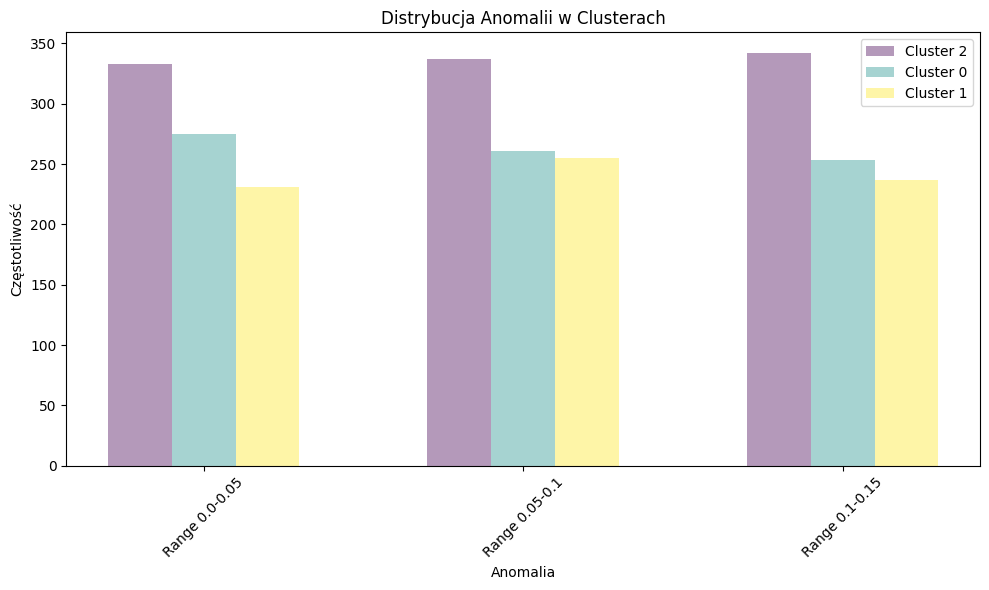

In [122]:
bins = [0.0, 0.05, 0.1, 0.15]

month_full_clean['Anomalia_Range'] = pd.cut(month_full_clean['Anomalia'], bins=bins)

num_clusters = len(bins) - 1
colors = plt.cm.viridis(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(10, 6))

bar_width = 0.2
cluster_numbers = month_full_clean['Cluster'].unique()

for i, cluster in enumerate(cluster_numbers):
    ax = plt.subplot(111)
    cluster_data = month_full_clean[month_full_clean['Cluster'] == cluster]
    bin_counts = cluster_data['Anomalia_Range'].value_counts().sort_index()
    bar_position = np.arange(len(bins) - 1) + i * bar_width
    
    ax.bar(bar_position, bin_counts, width=bar_width, alpha=0.4, label=f'Cluster {cluster}', color=colors[i])

plt.title('Distrybucja Anomalii w Clusterach')
plt.xlabel('Anomalia')
plt.ylabel('Częstotliwość')
plt.legend()
plt.xticks(np.arange(len(bins) - 1) + bar_width * ((len(cluster_numbers) - 1) / 2), [f'Range {bins[i]}-{bins[i+1]}' for i in range(len(bins) - 1)], rotation=45)
plt.tight_layout()
plt.show()

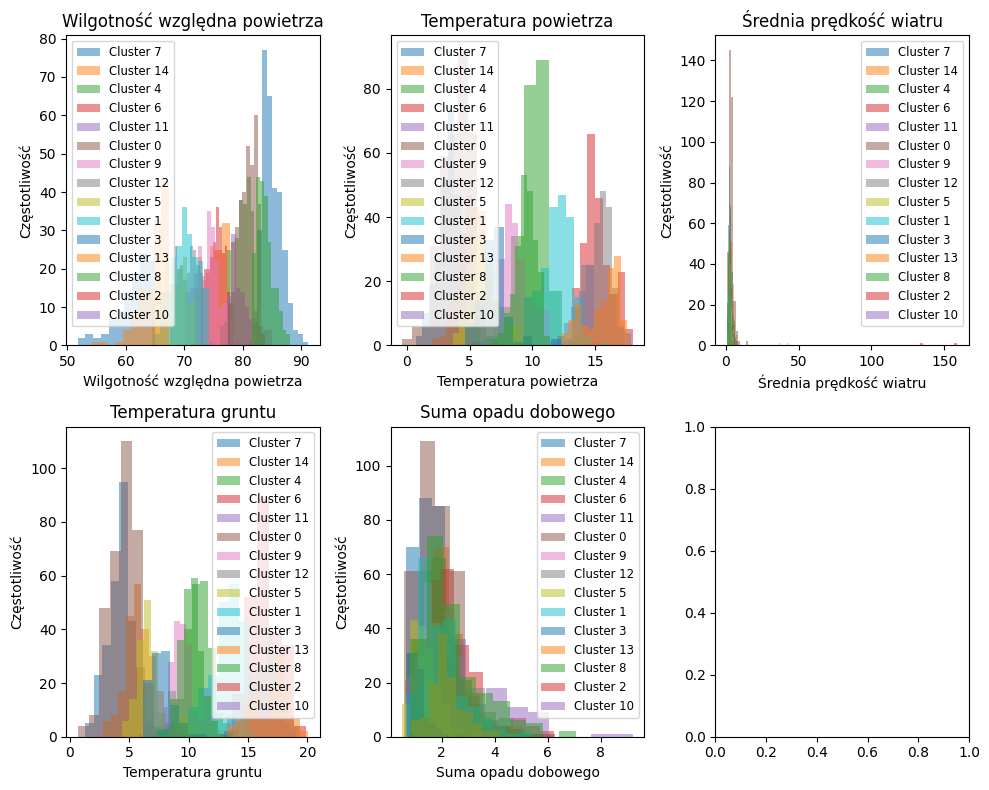

In [123]:
columns_for_clustering = ['Wilgotność względna powietrza', 'Temperatura powietrza', 'Średnia prędkość wiatru', 'Temperatura gruntu', 'Suma opadu dobowego']

data_for_clustering = month_full_clean[columns_for_clustering]


scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

kmeans = KMeans(n_clusters=15, random_state=42)
month_full_clean['Cluster'] = kmeans.fit_predict(data_for_clustering)

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, column in enumerate(columns_for_clustering):
    row = i // 3
    col = i % 3
    for cluster in month_full_clean['Cluster'].unique():
        cluster_data = month_full_clean[month_full_clean['Cluster'] == cluster]
        axs[row, col].hist(cluster_data[column], alpha=0.5, label=f'Cluster {cluster}')
        axs[row, col].set_xlabel(column)
        axs[row, col].set_ylabel('Częstotliwość')
        axs[row, col].legend(fontsize='small')
        axs[row, col].title.set_fontsize(10)
        axs[row, col].set_title(f'{column}')

# Adjust layout
plt.tight_layout()
plt.show()

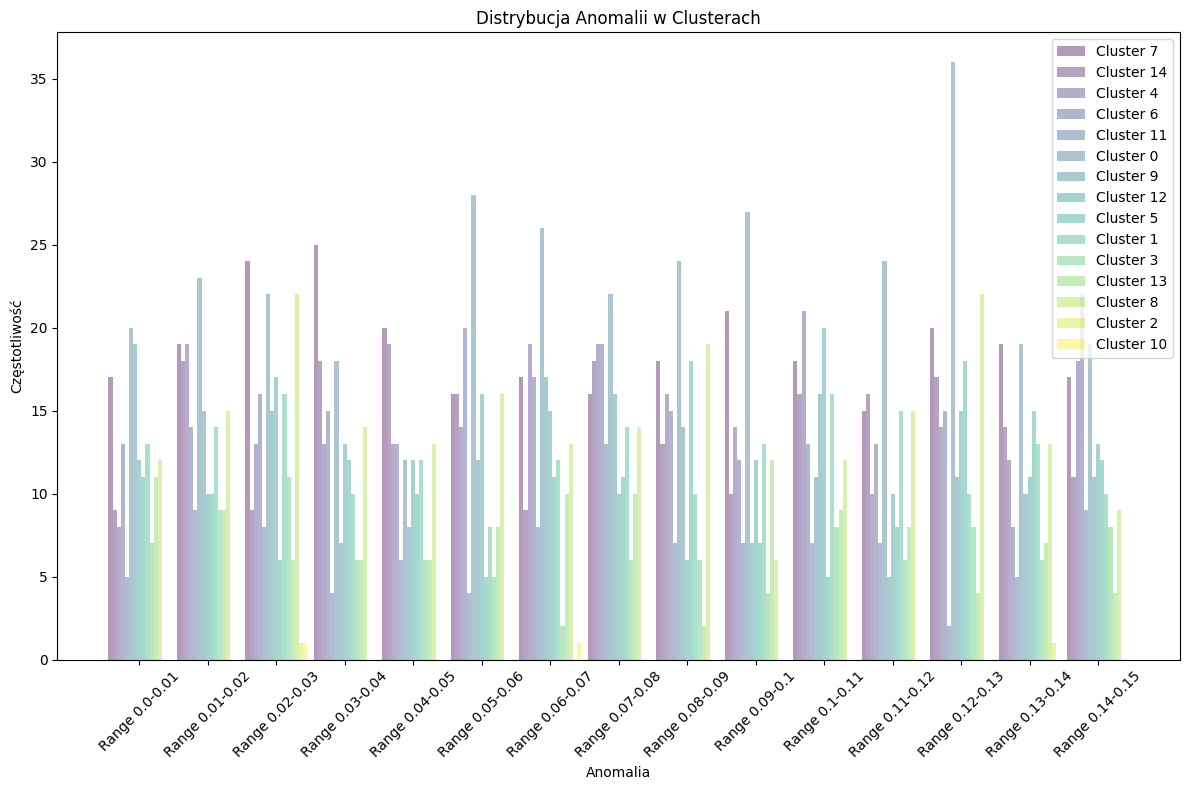

In [124]:
bins = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
month_full_clean['Anomalia_Range'] = pd.cut(month_full_clean['Anomalia'], bins=bins)

num_clusters = len(bins) - 1
colors = plt.cm.viridis(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(12, 8))

bar_width = 0.06 
cluster_numbers = month_full_clean['Cluster'].unique()

for i, cluster in enumerate(cluster_numbers):
    ax = plt.subplot(111)
    cluster_data = month_full_clean[month_full_clean['Cluster'] == cluster]
    bin_counts = cluster_data['Anomalia_Range'].value_counts().sort_index()
    bar_position = np.arange(len(bins) - 1) + i * bar_width
    
    ax.bar(bar_position, bin_counts, width=bar_width, alpha=0.4, label=f'Cluster {cluster}', color=colors[i])

plt.title('Distrybucja Anomalii w Clusterach')
plt.xlabel('Anomalia')
plt.ylabel('Częstotliwość')
plt.legend()
plt.xticks(np.arange(len(bins) - 1) + bar_width * ((len(cluster_numbers) - 1) / 2), [f'Range {bins[i]}-{bins[i+1]}' for i in range(len(bins) - 1)], rotation=45)
plt.tight_layout()
plt.show()

### Random forest

Do tego algorytmu została dodana informacja o miesiącu, ponieważ wartości pogodowe zależą od pory roku. Niemniej jednak, mimo tej modyfikacji, algorytm osiąga negatywną ```Accuracy```, co również świadczy, że nie będzie to optymalny sposób na przewidywanie anomalii.

In [125]:
def calculate_accuracy(data, bins_list, labels_list, year):
    for bins, labels in zip(bins_list, labels_list):
        data['bin'] = pd.cut(data['Anomalia'], bins=bins, labels=labels, include_lowest=True)
        data['month'] = data['Data_godzina'].dt.month

        columns_for_clustering = ['month', 'Wilgotność względna powietrza', 
                                  'Temperatura powietrza', 'Średnia prędkość wiatru', 
                                  'Temperatura gruntu', 'Suma opadu dobowego']

        X = data[columns_for_clustering]
        y = data['bin']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        accuracy = rf.score(X_test, y_test)
        print(f"Accuracy w roku {year} dla koszy {len(bins)-1}: {accuracy}")

bins_list = [
    [0.0, 0.05, 0.1, 0.15],
    [0.0, 0.03, 0.06, 0.09, 0.12, 0.15],
    [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
]

labels_list = [
    [1, 2, 3],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
]

month_full_clean = month_avg.dropna(how='any').copy()

calculate_accuracy(month_full_clean[month_full_clean['Data_godzina'].dt.year == 2017], bins_list, labels_list, 2017)
print("\n")
calculate_accuracy(month_full_clean[month_full_clean['Data_godzina'].dt.year == 2022], bins_list, labels_list, 2022)



Accuracy w roku 2017 dla koszy 3: -0.0753573323403911
Accuracy w roku 2017 dla koszy 5: -0.06085292159528355
Accuracy w roku 2017 dla koszy 15: -0.06830534012349498


Accuracy w roku 2022 dla koszy 3: -0.1561766398701694
Accuracy w roku 2022 dla koszy 5: -0.08400768578728735
Accuracy w roku 2022 dla koszy 15: -0.10757914075554553


In [126]:
day_clean = day_avg.dropna(how='any').copy()
print(day_clean.shape[0])

77660


Użycie danych dziennych w porównaniu z danymi miesięcznymi również nie przyniosło poprawy wyników.

_Ta komórka wykonuje się dłużej niż pozostałe_

In [127]:
def calculate_accuracy(data, bins_list, labels_list, year):
    for bins, labels in zip(bins_list, labels_list):
        data['bin'] = pd.cut(data['Anomalia'], bins=bins, labels=labels, include_lowest=True)
        data['month'] = data['Data_godzina'].dt.month

        columns_for_clustering = ['month', 'Wilgotność względna powietrza', 
                                  'Temperatura powietrza', 'Średnia prędkość wiatru', 
                                  'Temperatura gruntu', 'Suma opadu dobowego', 'bin']

        selected_data = data[columns_for_clustering]

        X = selected_data.drop('bin', axis=1)
        y = selected_data['bin']

        X_array = X.values 
        y_array = y.values


        X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        accuracy = rf.score(X_test, y_test)
        print(f"Accuracy w roku {year} dla koszy {len(bins)-1}: {accuracy}")

bins_list = [
    [0.0, 0.05, 0.1, 0.15],
    [0.0, 0.03, 0.06, 0.09, 0.12, 0.15],
    [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
]

labels_list = [
    [1, 2, 3],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
]

day_clean = day_avg.dropna(how='any').copy()
calculate_accuracy(day_clean[day_clean['Data_godzina'].dt.year == 2017], bins_list, labels_list, 2017)
print("\n")
calculate_accuracy(day_clean[day_clean['Data_godzina'].dt.year == 2022], bins_list, labels_list, 2022)


Accuracy w roku 2017 dla koszy 3: -0.0503168765230384
Accuracy w roku 2017 dla koszy 5: -0.0475543083041321
Accuracy w roku 2017 dla koszy 15: -0.04636282876711806


Accuracy w roku 2022 dla koszy 3: -0.027818305701694745
Accuracy w roku 2022 dla koszy 5: -0.027695293619604433
Accuracy w roku 2022 dla koszy 15: -0.025287766384924026


W przypadku komórki powyżej, taki niski wynik ma sens - wszystkie dane pogodowe z danego miesiąca są porównywane do tego samego wyniku anomalii. Innymi słowy, 30 dni z różnymi wartościami mają takie same wyniki w postaci anomalii.

Wpadłam na pomysł rozwiązania tego problemu, niestety tuż przed deadlinem. Dlatego sekcja poniżej będzie tylko szkicem rozwiązania.

Znalezienie dni dla których wszystkie stacje mają zawsze dane w każdym miesiącu

In [128]:
day_clean = day_avg.dropna(how='any').copy()
day_clean.rename(columns={'ID_stacji' : 'ID'}, inplace=True)

day_clean['Day_number'] = day_clean['Data_godzina'].dt.day

station_day_count = day_clean.groupby(['ID', 'Day_number'])['Data_godzina'].nunique().reset_index()

days_with_data_per_station = station_day_count.groupby('ID')['Day_number'].unique()

common_days_for_all_stations = [day for day in range(1, 29) if all(day in days for days in days_with_data_per_station)]

print("Wspólne dnie dla wszystkich stacji:", common_days_for_all_stations)


Wspólne dnie dla wszystkich stacji: [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


Przekstałacenie w dataframe tak by dla jednego wyniku w Anomalli wartosci pogodowe były w arrayach a nie osobnych komórkach.

In [129]:
day_clean_filtered = day_clean[day_clean['Day_number'].isin(common_days_for_all_stations)]

def collect_values_as_array(x):
    if x.empty:
        return np.nan
    else:
        return x.tolist()

agg_funcs = {col: collect_values_as_array if col in value_cols else 'first' for col in day_clean_filtered.columns}

# Group by ID_stacji and month, then aggregate using the defined functions
month_values_common_days = day_clean_filtered.groupby(['ID', day_clean_filtered['Data_godzina'].dt.to_period('M')]).agg(agg_funcs)
month_values_common_days.head(2)

ID Data_godzina  \
ID Data_godzina                    
2  2017-01        2   2017-01-13   
   2017-02        2   2017-02-17   

                                     Wilgotność względna powietrza  \
ID Data_godzina                                                      
2  2017-01       [94.875, 88.75, 94.625, 90.75, 76.375, 92.75, ...   
   2017-02       [80.83333333333333, 79.125, 71.04166666666667,...   

                                               Suma opadu dobowego  \
ID Data_godzina                                                      
2  2017-01       [0.6, 0.7, 0.2, 0.1, 0.9, 0.7, 0.5, 1.4, 0.5, ...   
   2017-02       [12.8, 3.5, 5.8, 1.7, 4.1, 0.4, 1.9, 0.3, 0.2,...   

                                                Temperatura gruntu  \
ID Data_godzina                                                      
2  2017-01       [4.945833333333334, 5.108333333333333, 1.97500...   
   2017-02       [6.462500000000001, 6.074999999999999, 5.2875,...   

                                           Średnia prędkość wiatru  \
ID Data_godzina                                                      
2  2017-01       [11.016666666666666, 11.229166666666666, 5.658...   
   2017-02       [14.058333333333332, 11.291666666666666, 14.54...   

                                             Temperatura powietrza    Nazwa  \
ID Data_godzina                                                               
2  2017-01       [4.4624999999999995, 4.3, 1.2958333333333334, ...  DZIWNÓW   
   2017-02       [5.979166666666667, 5.741666666666667, 5.10416...  DZIWNÓW   

                 Szerokość geograficzna  Długość geograficzna  bts_id    siec  \
ID Data_godzina                                                                 
2  2017-01                    54.022222             14.731667   100.0  Orange   
   2017-02                    54.022222             14.731667   100.0  Orange   

                    standard  Anomalia  Day_number  
ID Data_godzina                                     
2  2017-01       GSM UMTS         0.04          13  
   2017-02       GSM UMTS         0.15          17

Następnie, jeśli każda kolumna z danymi pogodowymi zawiera tablicę o tej samej ilości elementów, te kolumny mogą zostać explode'owane, aby wykorzystać wszystkie dane z tych samych dni miesiąca do przewidywania anomalii, a nie tylko ich średnich wartości.

W przypadku, gdy to rozwiązanie nie zadziałałoby, inny sposób zakłada zapis danych w formacie, w którym dane zostałyby ułożone w sposób  
```[ [1, 2, 3, 4, 5] ..... [1, 2, 3, 4, 5]]```,  
gdzie liczby od 1 do 5 reprezentują wartości pogodowe dla każdego dnia miesiąca (uwzględniając tylko wspólne dni).

Ten format danych mógłby być również wykorzystany w sieciach neuronowych konwolucyjnych (CNN), ponieważ jego układ przypomina sposób zapisu pikseli w obrazie. Niemniej jednak, wartości prawdopodobnie musiałby być znormalizowane, aby zastosowanie CNN było skuteczne.by być również użyte do CNN ponieważ zapis jest podobny do zapisu pixeli w obrazie - prawdopodobnie warto sci musiałyby być znormalizowane.